# Telecom Churn - Group Case Study- Farzana

## Problem Statement
 

## Business Problem Overview


In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Understanding and Defining Churn
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

 

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

 

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

 

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.

 

This project is based on the Indian and Southeast Asian market.

 

## Definitions of Churn
There are various ways to define churn, such as:

Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

 

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

 

## Usage-based churn: 

Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

 

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

 

In this project, you will use the usage-based definition to define churn.

 

## High-value Churn
In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

 

In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

## Understanding the Business Objective and the Data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import statsmodels.formula.api as sm
#import scipy.stats as stats
#from imblearn.over_sampling import SMOTE
#from sklearn.model_selection import train_test_split
#from sklearn.decomposition import PCA
#from sklearn.linear_model import LogisticRegression
#from sklearn import metrics
#from sklearn.metrics import confusion_matrix

# Reading and Cleaning data

In [2]:
class Data_cleaner():
    
    def __init__(self, df=None):
        self.df = df
    
    def import_data(self):
        self.df=pd.read_csv('telecom_churn_data.csv')
        return self

    def dropping_na(self):
        self.df.fillna(0,inplace=True)
        return self    

    def fill_na(self):
        self.df.fillna(0,inplace=True)
        return self
    
    def dropping_single_col(self):
        drop_cols = list(filter(lambda x : len(self.df[x].value_counts()) < 2, self.df.columns))
        self.df.drop(drop_cols,axis=1, inplace=True)   
        return self

    def filtering_high_val_cust(self):
        # Deriving new column for Average Recharge Amount in 6 & 7 months....
        self.df['d_av_rech_amt'] = round((self.df['total_rech_amt_6'] + self.df['total_rech_amt_7'])/2,2)
        self.df['d_av_rech_amt_data'] = round((self.df['av_rech_amt_data_6']+self.df['av_rech_amt_data_7'])/2,2)
        # Filtering High Value Customers
        self.df = self.df.loc[(self.df['d_av_rech_amt'] > self.df['d_av_rech_amt'].quantile(0.70)) |
                  (self.df['d_av_rech_amt_data'] > self.df['d_av_rech_amt_data'].quantile(0.70))]
        self.df.drop(['d_av_rech_amt','d_av_rech_amt_data'], axis=1, inplace=True)
        return self    
    
    def tagging_churner(self):
        churn_phase = self.df.loc[:,['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']]
        churners = pd.DataFrame()
        churners =self.df.loc[(churn_phase.total_ic_mou_9 == 0.00) 
                            & (churn_phase.total_og_mou_9 == 0.00)
                            & (churn_phase.vol_2g_mb_9 == 0.00)
                            & (churn_phase.vol_3g_mb_9 == 0.00), ['mobile_number']
                           ]
        # Adding a new column for Churn....
        churners['churn'] = 1
        # Merging 2 dataframes to all churn column....
        self.df = pd.merge(self.df, churners, how='outer', on='mobile_number')
        self.df['churn'] = self.df['churn'].fillna(0)
        self.df['churn'] = self.df['churn'].astype(int)
        # Dropping the 9th month columns.... 
        mont_9_columns = list(map(lambda x : x.endswith('_9'),self.df.columns))
        self.df.drop(self.df.loc[:,mont_9_columns],axis = 1, inplace=True)     
        return self
       
    def removing_neg_arpu(self):
        # Removing all records with negative values in Revenue columms....
        self.df = self.df.loc[(self.df.arpu_6 > 0) & (self.df.arpu_7 > 0) & (self.df.arpu_8 >0)]
        return self
    
    def imputing_night_pack_user(self):
        self.df['night_pck_user_6'] =self.df.loc[:,'night_pck_user_6'].fillna(-1).astype(int)
        self.df['night_pck_user_7'] =self.df.loc[:,'night_pck_user_7'].fillna(-1).astype(int)
        self.df['night_pck_user_8'] =self.df.loc[:,'night_pck_user_8'].fillna(-1).astype(int)
        return self
    
    def imputing_fb_user(self):
        self.df['fb_user_6'] =self.df.loc[:,'fb_user_6'].fillna(-1).astype(int)
        self.df['fb_user_7'] =self.df.loc[:,'fb_user_7'].fillna(-1).astype(int)
        self.df['fb_user_8'] =self.df.loc[:,'fb_user_8'].fillna(-1).astype(int)
        return self
    
    def dropping_mob_no_col(self):
        self.df.drop('mobile_number',axis=1,inplace=True)
        return self
    
    def fixing_col_names(self):
        self.df.rename(columns={'jun_vbc_3g': 'vbc_3g_6',
                                'jul_vbc_3g': 'vbc_3g_7',
                                'aug_vbc_3g': 'vbc_3g_8',
                                'sep_vbc_3g': 'vbc_3g_9'
                               }, inplace=True)
        return self

In [3]:
cleaned_data_df = ( Data_cleaner()
    .import_data()
    .dropping_single_col()
    .fill_na()
    .filtering_high_val_cust()
    .fixing_col_names()
    .tagging_churner()
    .removing_neg_arpu() 
    .imputing_night_pack_user()       
    .imputing_fb_user()  
    ).df

In [4]:
cleaned_data_df.shape

(42984, 159)

In [5]:
cleaned_data_df.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
0     7000842753   197.385   214.816   213.803         0.00         0.00   
1     7001865778    34.047   355.074   268.321        24.11        78.68   
2     7000142493   261.636   309.876   238.174        50.31       149.44   
3     7000701601  1069.180  1349.850  3171.480        57.84        54.68   
4     7001524846   378.721   492.223   137.362       413.69       351.03   

   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  sachet_3g_7  \
0         0.00          0.00          0.00          0.00  ...            0   
1         7.68         15.74         99.84        304.76  ...            0   
2        83.89         76.96         91.88        124.26  ...            0   
3        52.29        453.43        567.16        325.91  ...            0   
4        35.08         94.66         80.63        136.48  ...            0   

   sachet_3g_8  fb_user_6  fb_user_7  fb_user_8   aon  vbc_3g_8  vbc_3g_7  \
0            0          1          1          1   968     30.40      0.00   
1            0          0          1          1  1006      0.00      0.00   
2            0          0          0          0  1526      0.00      0.00   
3            0          0          0          0   802     57.74     19.38   
4            0          0          1          1   315     21.03    910.65   

   vbc_3g_6  churn  
0    101.20      1  
1      0.00      0  
2      0.00      0  
3     18.74      1  
4    122.16      0  

[5 rows x 159 columns]

In [6]:
cleaned_data_df.describe()

mobile_number        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count   4.298400e+04  42984.000000  42984.000000  42984.000000  42984.000000   
mean    7.001207e+09    453.292662    462.179924    436.261773    209.296685   
std     6.898995e+05    405.452116    428.732532    440.874024    396.884071   
min     7.000000e+09      0.010000      0.010000      0.010000      0.000000   
25%     7.000612e+09    217.272250    226.560750    189.178500     11.510000   
50%     7.001206e+09    378.155000    382.788000    352.062000     62.180000   
75%     7.001803e+09    577.824750    584.992500    565.612500    218.645000   
max     7.002411e+09  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  42984.000000  42984.000000  42984.000000  42984.000000  42984.000000   
mean     218.443814    198.318124    300.231065    309.652710    283.658828   
std      419.339372    405.298313    413.856850    435.185114    421.013821   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       11.080000      8.980000     49.675000     50.230000     40.080000   
50%       62.210000     52.630000    168.210000    171.040000    147.150000   
75%      226.830000    195.965000    387.687500    398.887500    366.290000   
max     8157.780000  10752.560000   8362.360000   9667.130000  14007.340000   

       ...   sachet_3g_7   sachet_3g_8     fb_user_6     fb_user_7  \
count  ...  42984.000000  42984.000000  42984.000000  42984.000000   
mean   ...      0.172413      0.167667      0.476596      0.490089   
std    ...      0.915214      0.959824      0.499458      0.499908   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      1.000000      1.000000   
max    ...     35.000000     41.000000      1.000000      1.000000   

          fb_user_8           aon      vbc_3g_8      vbc_3g_7      vbc_3g_6  \
count  42984.000000  42984.000000  42984.000000  42984.000000  42984.000000   
mean       0.450796   1220.327634    141.075353    142.117103    124.221205   
std        0.497579    962.656338    374.714662    385.855201    360.091925   
min        0.000000    180.000000      0.000000      0.000000      0.000000   
25%        0.000000    461.000000      0.000000      0.000000      0.000000   
50%        0.000000    858.000000      0.000000      0.000000      0.000000   
75%        1.000000   1806.000000     75.235000     69.477500     38.247500   
max        1.000000   4321.000000  12916.220000   9165.600000  11166.210000   

              churn  
count  42984.000000  
mean       0.058464  
std        0.234621  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 153 columns]

# Performing EDA

### Checking if all the rows are unique....

In [7]:
cleaned_data_df.mobile_number.value_counts().sort_values(ascending = False)[0:10]

7000883200    1
7001344001    1
7000891396    1
7001859384    1
7000963079    1
7001292808    1
7001557001    1
7000971275    1
7001366540    1
7000455183    1
Name: mobile_number, dtype: int64

## Checking datatypes

In [8]:
cleaned_data_df.iloc[:,0:40].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42984 entries, 0 to 46554
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mobile_number     42984 non-null  int64  
 1   arpu_6            42984 non-null  float64
 2   arpu_7            42984 non-null  float64
 3   arpu_8            42984 non-null  float64
 4   onnet_mou_6       42984 non-null  float64
 5   onnet_mou_7       42984 non-null  float64
 6   onnet_mou_8       42984 non-null  float64
 7   offnet_mou_6      42984 non-null  float64
 8   offnet_mou_7      42984 non-null  float64
 9   offnet_mou_8      42984 non-null  float64
 10  roam_ic_mou_6     42984 non-null  float64
 11  roam_ic_mou_7     42984 non-null  float64
 12  roam_ic_mou_8     42984 non-null  float64
 13  roam_og_mou_6     42984 non-null  float64
 14  roam_og_mou_7     42984 non-null  float64
 15  roam_og_mou_8     42984 non-null  float64
 16  loc_og_t2t_mou_6  42984 non-null  float6

In [9]:
cleaned_data_df.iloc[:,80:130].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42984 entries, 0 to 46554
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   total_ic_mou_7            42984 non-null  float64
 1   total_ic_mou_8            42984 non-null  float64
 2   spl_ic_mou_6              42984 non-null  float64
 3   spl_ic_mou_7              42984 non-null  float64
 4   spl_ic_mou_8              42984 non-null  float64
 5   isd_ic_mou_6              42984 non-null  float64
 6   isd_ic_mou_7              42984 non-null  float64
 7   isd_ic_mou_8              42984 non-null  float64
 8   ic_others_6               42984 non-null  float64
 9   ic_others_7               42984 non-null  float64
 10  ic_others_8               42984 non-null  float64
 11  total_rech_num_6          42984 non-null  int64  
 12  total_rech_num_7          42984 non-null  int64  
 13  total_rech_num_8          42984 non-null  int64  
 14  total_

In [10]:
cleaned_data_df.iloc[:,40:80].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42984 entries, 0 to 46554
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   std_og_mou_6      42984 non-null  float64
 1   std_og_mou_7      42984 non-null  float64
 2   std_og_mou_8      42984 non-null  float64
 3   isd_og_mou_6      42984 non-null  float64
 4   isd_og_mou_7      42984 non-null  float64
 5   isd_og_mou_8      42984 non-null  float64
 6   spl_og_mou_6      42984 non-null  float64
 7   spl_og_mou_7      42984 non-null  float64
 8   spl_og_mou_8      42984 non-null  float64
 9   og_others_6       42984 non-null  float64
 10  og_others_7       42984 non-null  float64
 11  og_others_8       42984 non-null  float64
 12  total_og_mou_6    42984 non-null  float64
 13  total_og_mou_7    42984 non-null  float64
 14  total_og_mou_8    42984 non-null  float64
 15  loc_ic_t2t_mou_6  42984 non-null  float64
 16  loc_ic_t2t_mou_7  42984 non-null  float6

In [11]:
cleaned_data_df.iloc[:,130:160].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42984 entries, 0 to 46554
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   arpu_3g_6         42984 non-null  float64
 1   arpu_3g_7         42984 non-null  float64
 2   arpu_3g_8         42984 non-null  float64
 3   arpu_2g_6         42984 non-null  float64
 4   arpu_2g_7         42984 non-null  float64
 5   arpu_2g_8         42984 non-null  float64
 6   night_pck_user_6  42984 non-null  int32  
 7   night_pck_user_7  42984 non-null  int32  
 8   night_pck_user_8  42984 non-null  int32  
 9   monthly_2g_6      42984 non-null  int64  
 10  monthly_2g_7      42984 non-null  int64  
 11  monthly_2g_8      42984 non-null  int64  
 12  sachet_2g_6       42984 non-null  int64  
 13  sachet_2g_7       42984 non-null  int64  
 14  sachet_2g_8       42984 non-null  int64  
 15  monthly_3g_6      42984 non-null  int64  
 16  monthly_3g_7      42984 non-null  int64 

## Univariate Analysis 

In [12]:
def plot_box(df, numeric_variable):
    sns.boxplot(y=df[numeric_variable])
    plt.title("DISTRIBUTION OF "+ numeric_variable)
    plt.show()

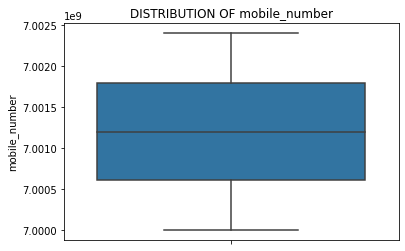

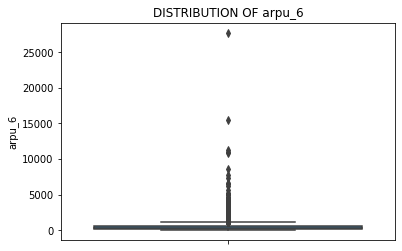

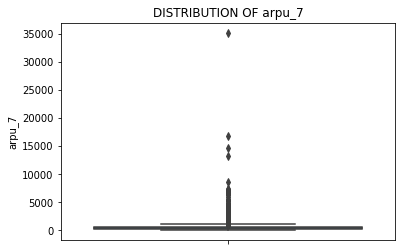

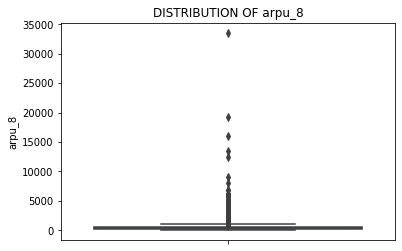

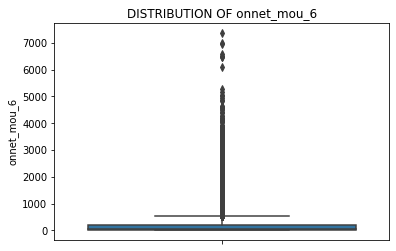

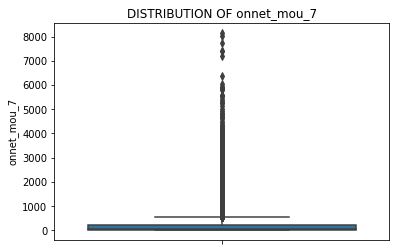

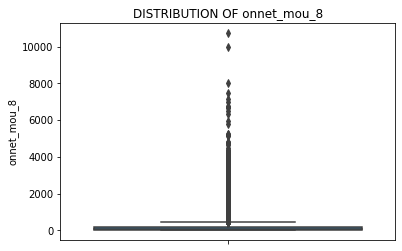

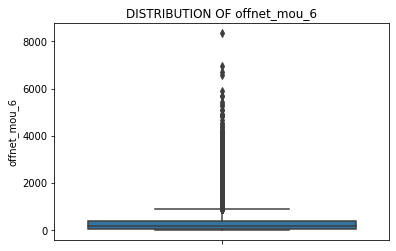

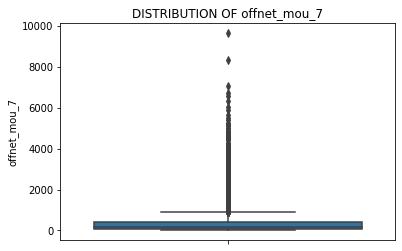

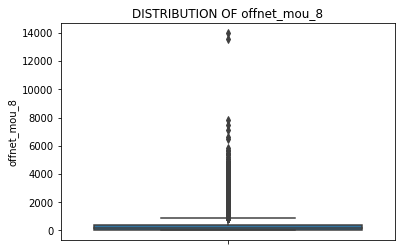

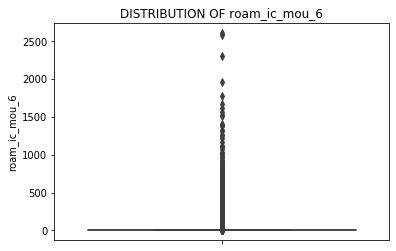

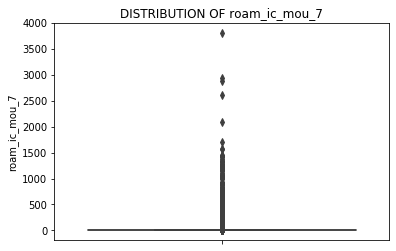

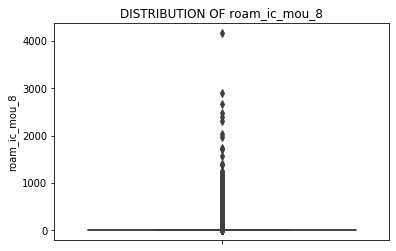

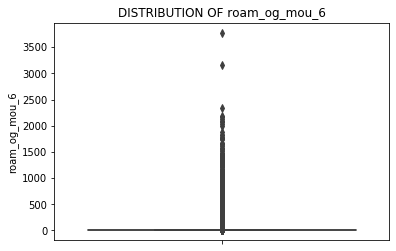

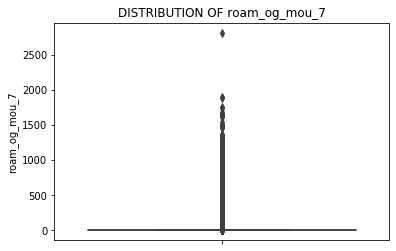

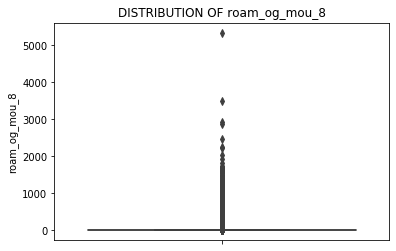

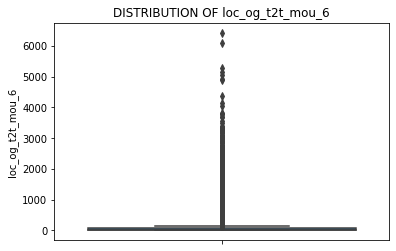

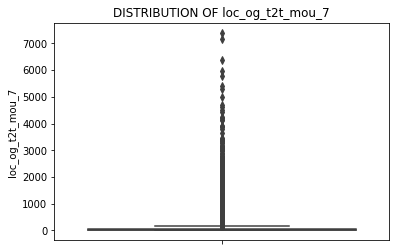

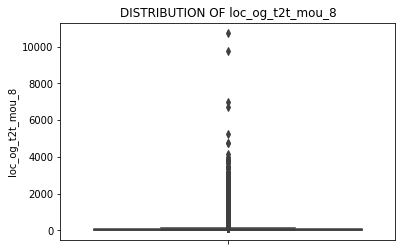

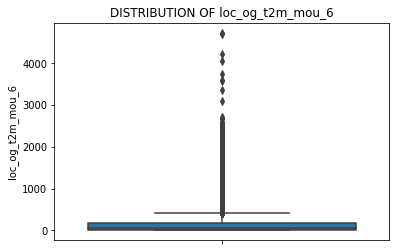

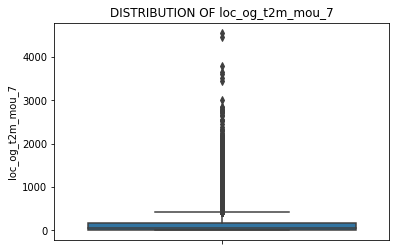

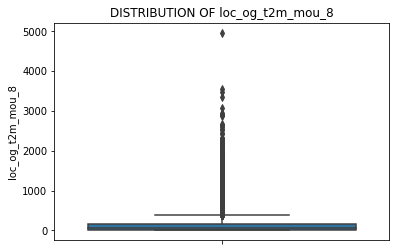

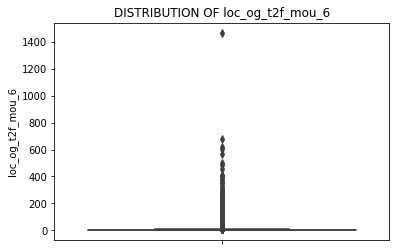

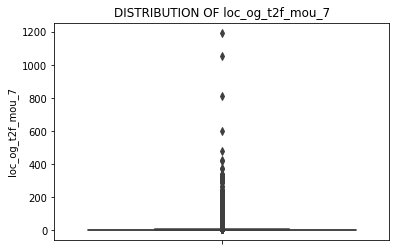

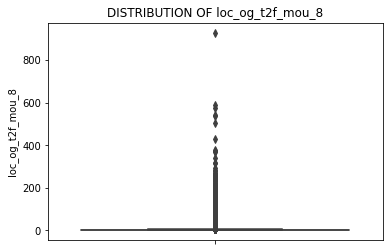

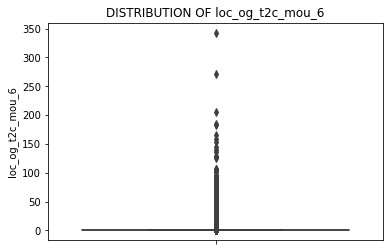

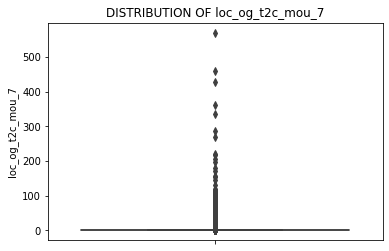

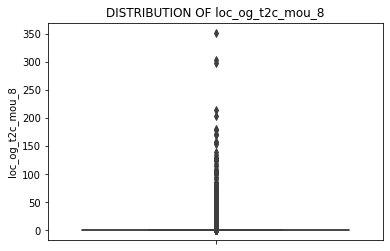

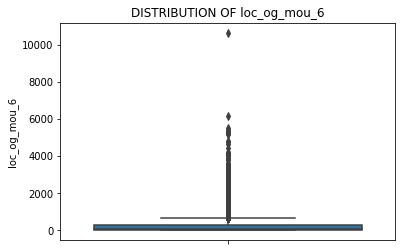

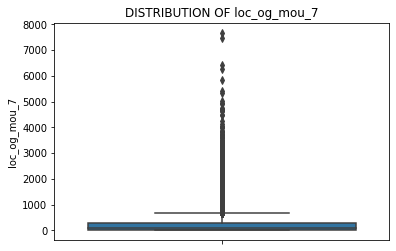

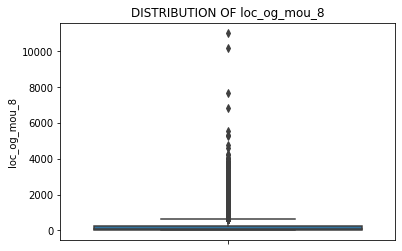

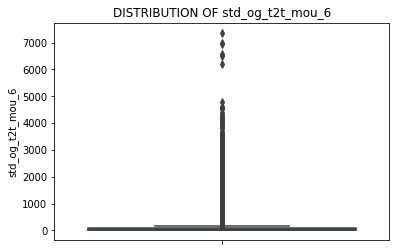

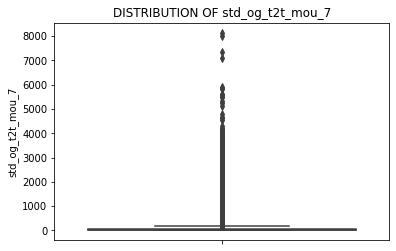

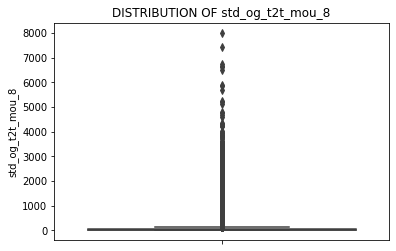

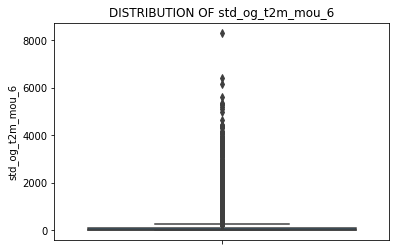

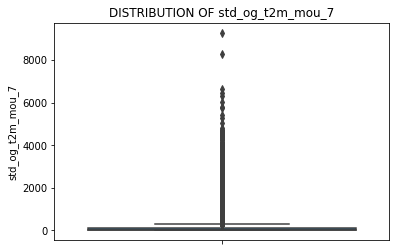

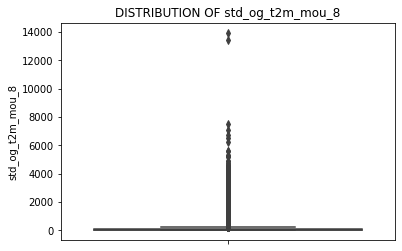

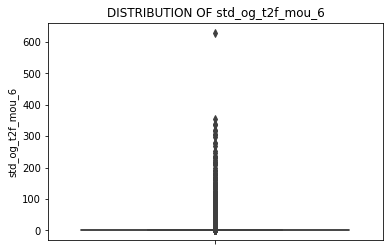

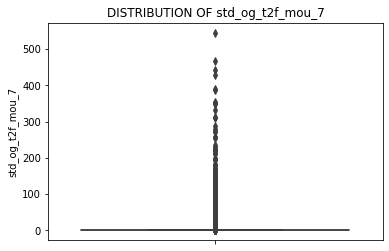

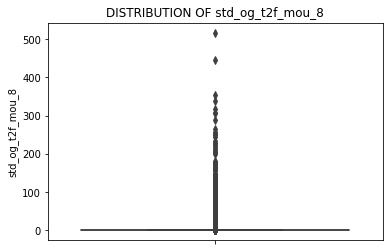

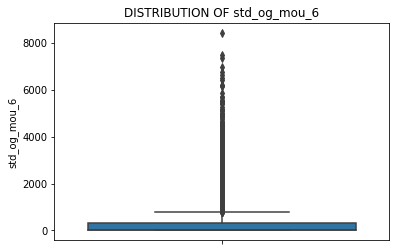

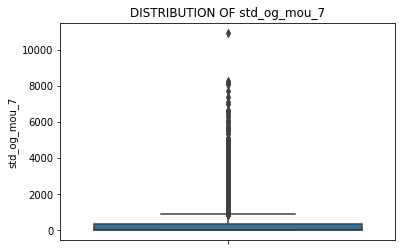

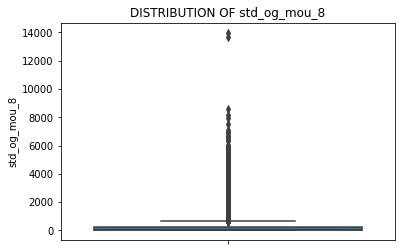

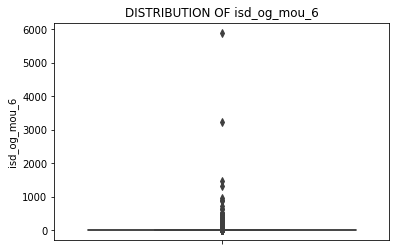

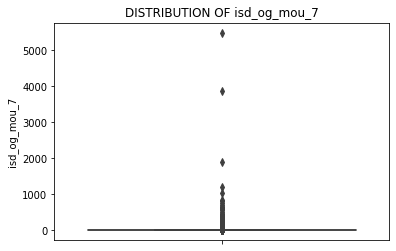

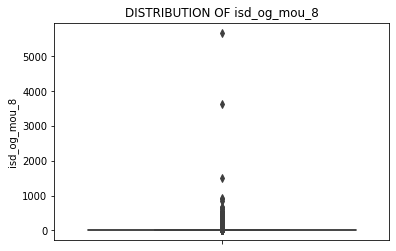

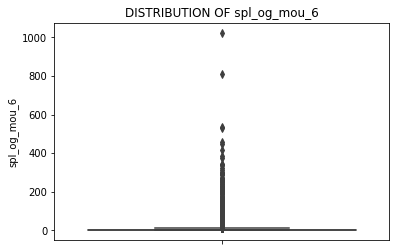

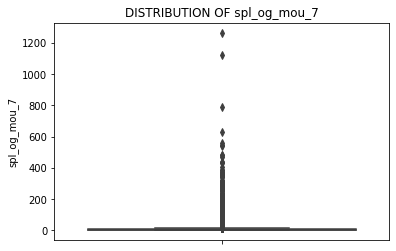

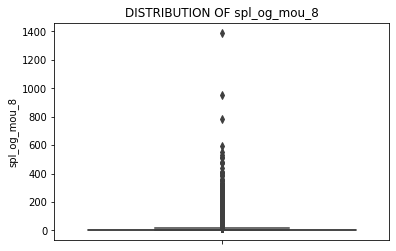

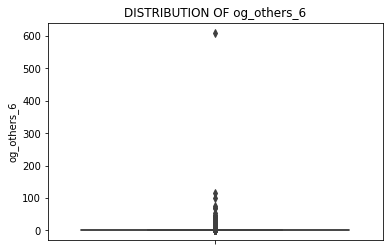

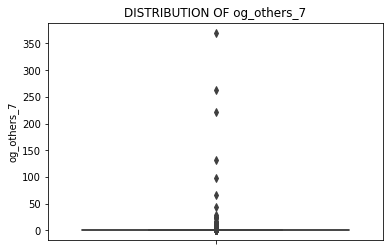

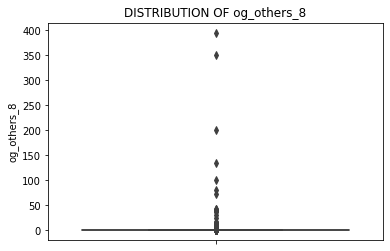

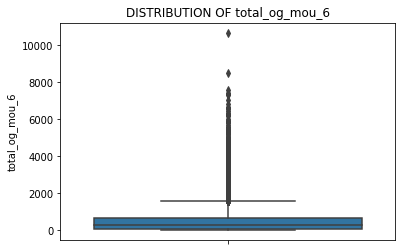

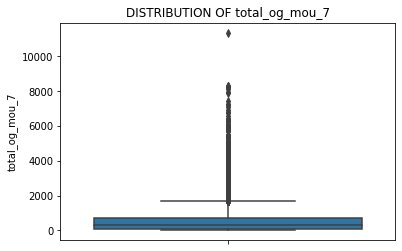

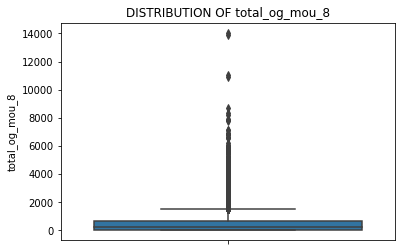

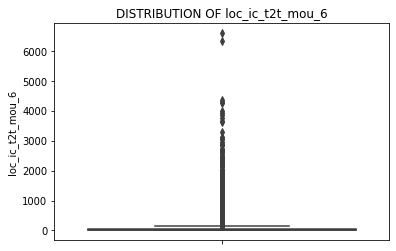

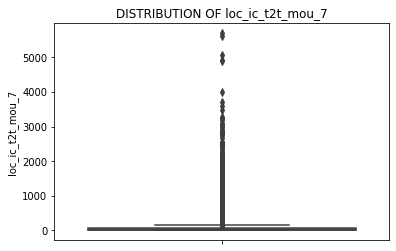

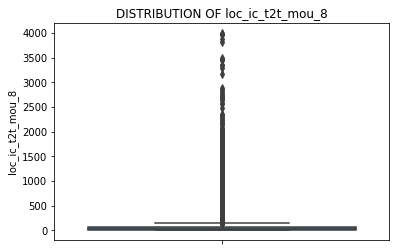

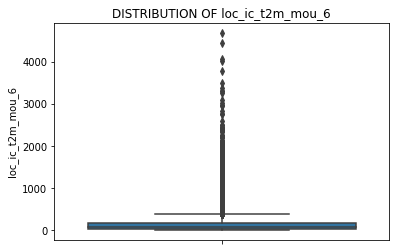

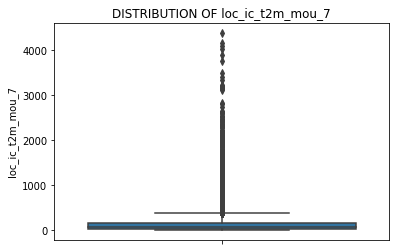

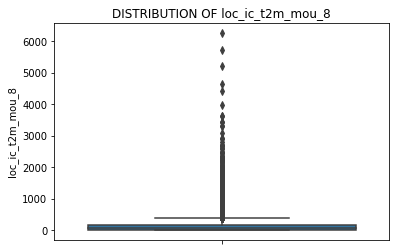

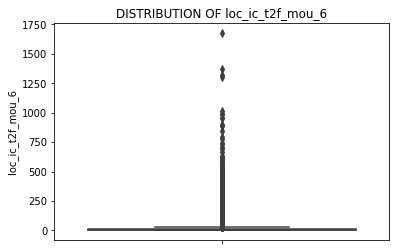

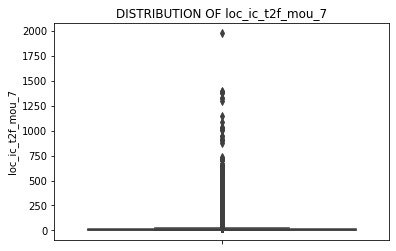

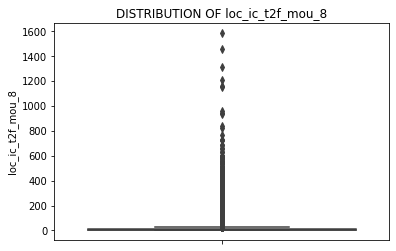

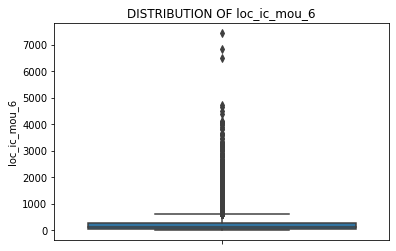

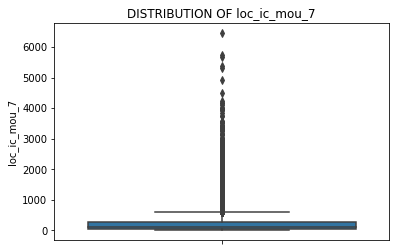

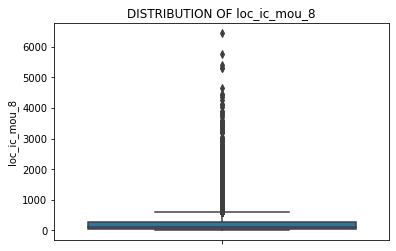

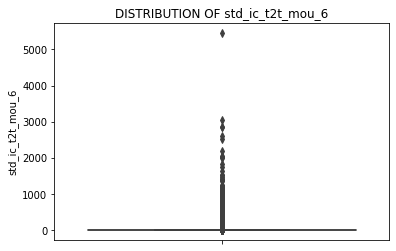

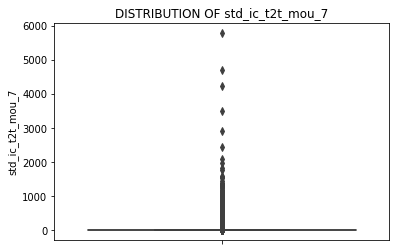

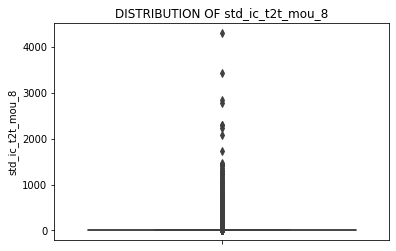

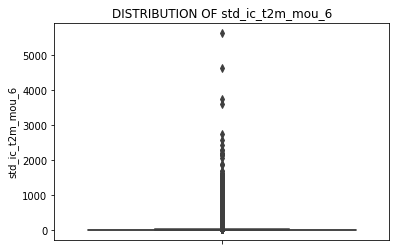

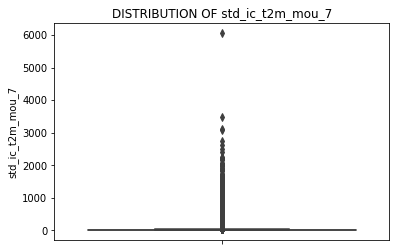

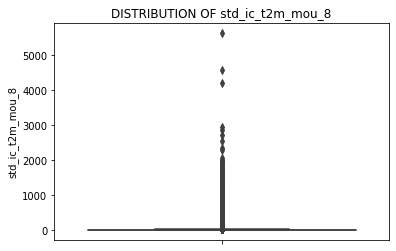

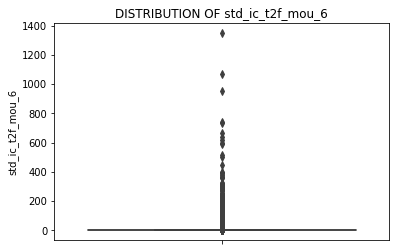

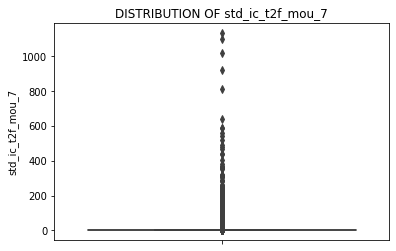

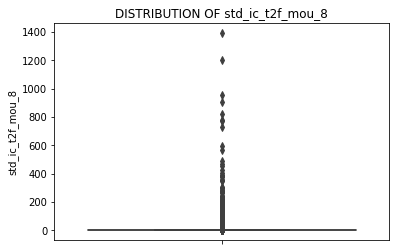

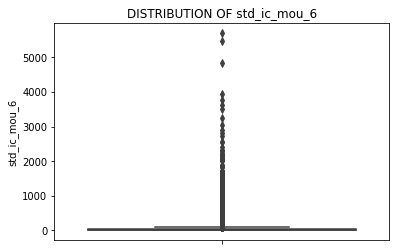

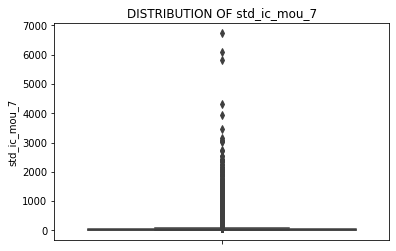

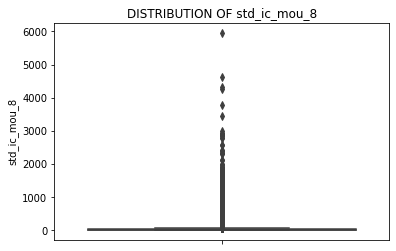

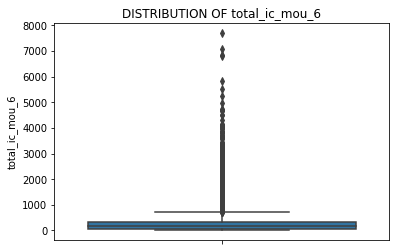

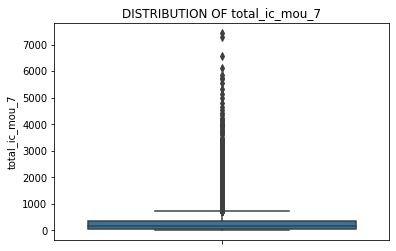

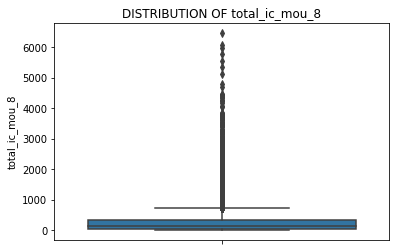

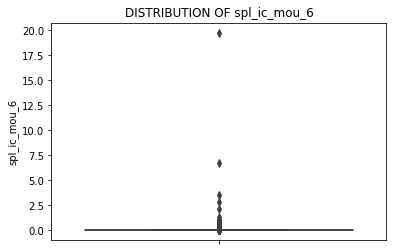

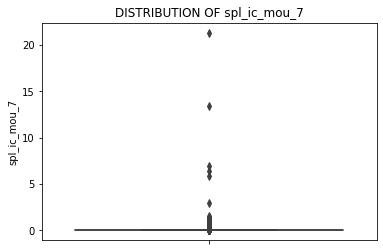

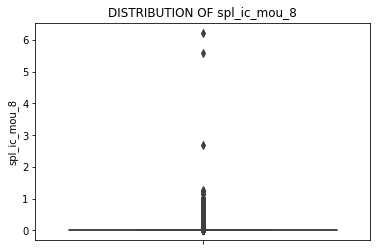

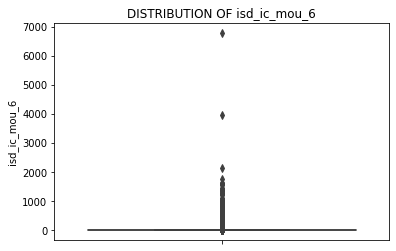

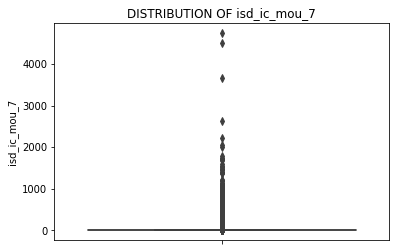

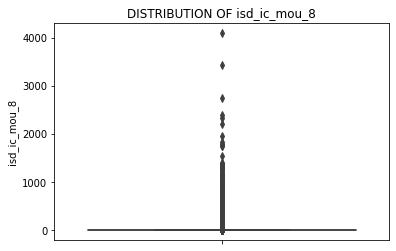

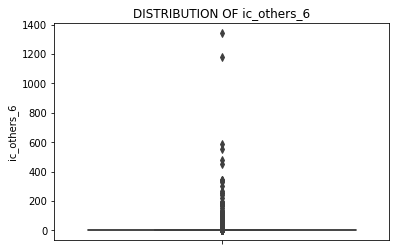

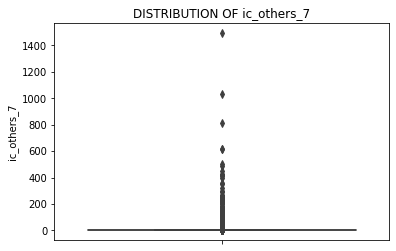

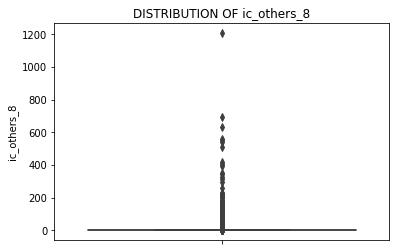

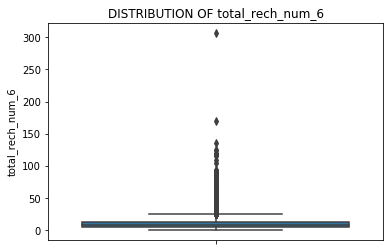

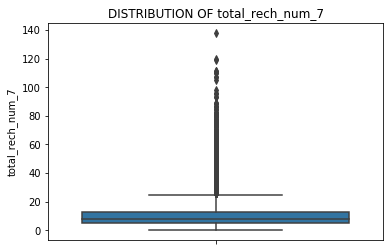

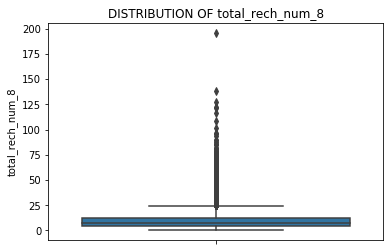

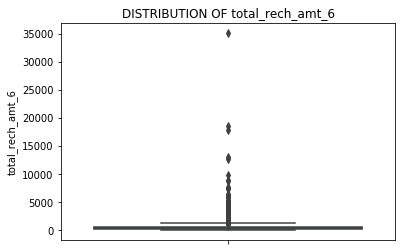

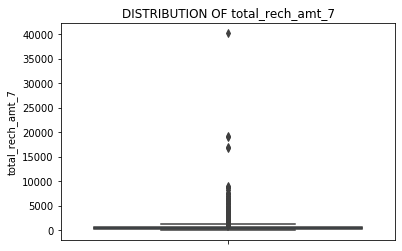

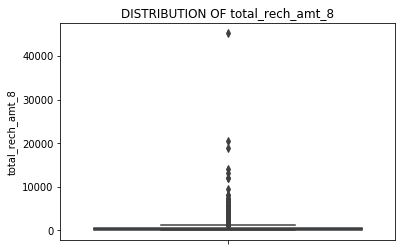

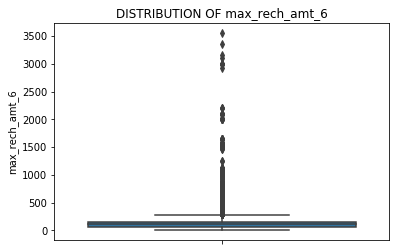

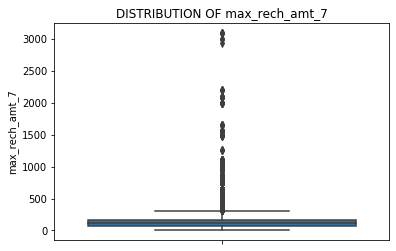

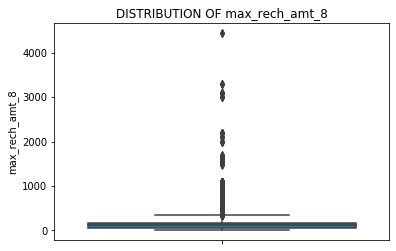

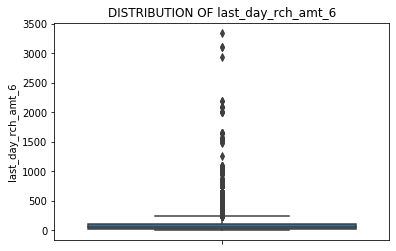

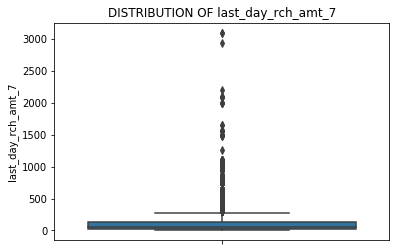

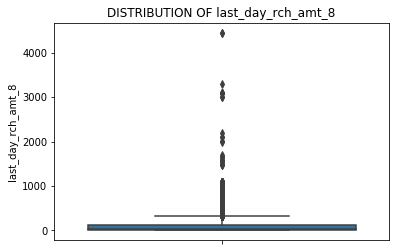

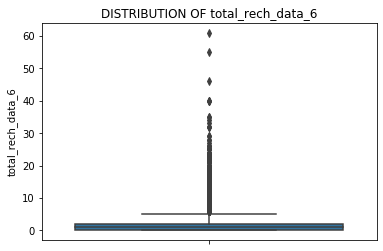

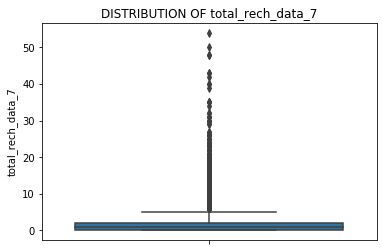

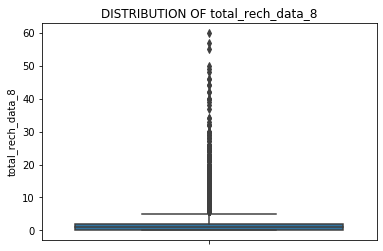

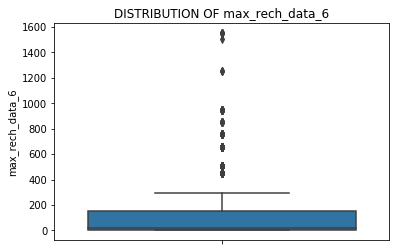

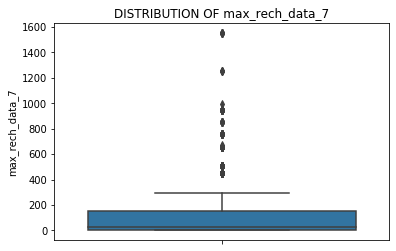

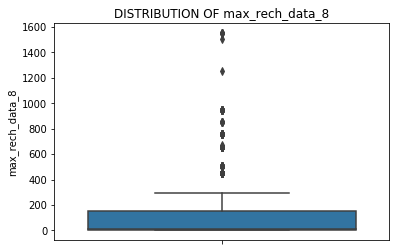

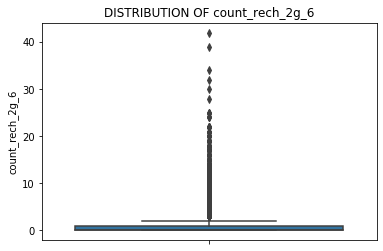

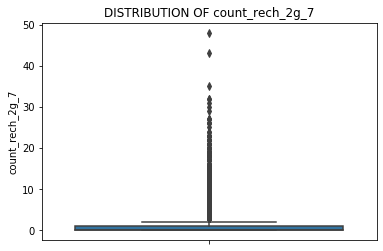

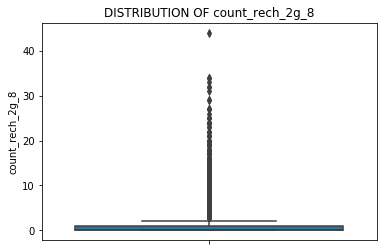

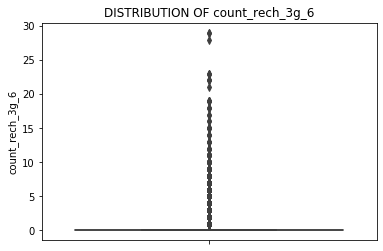

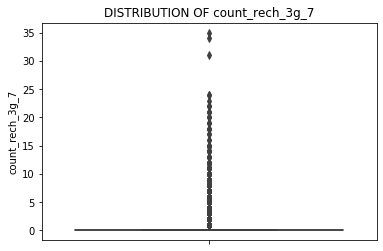

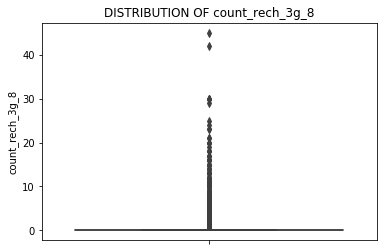

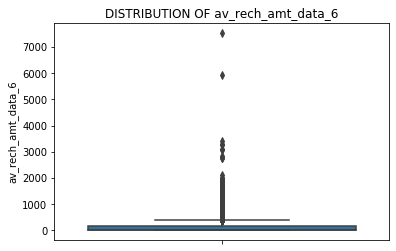

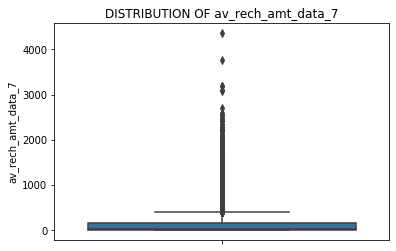

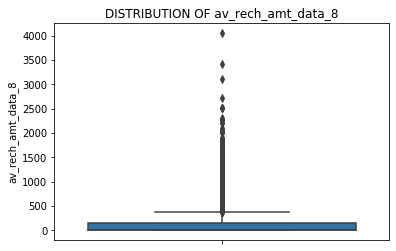

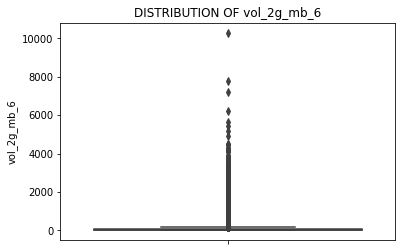

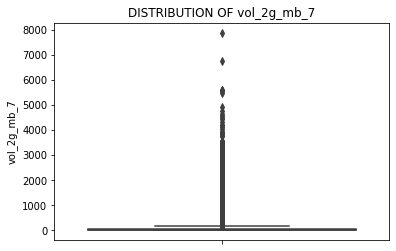

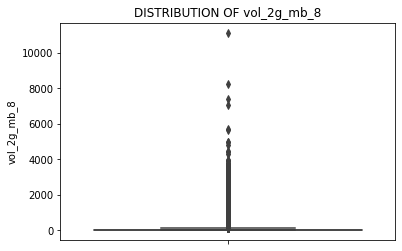

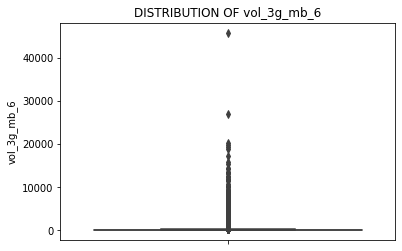

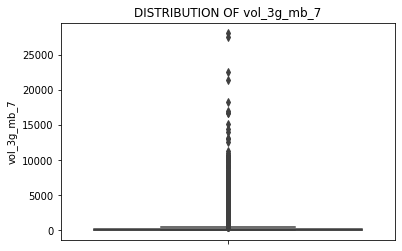

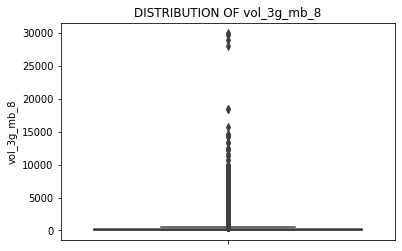

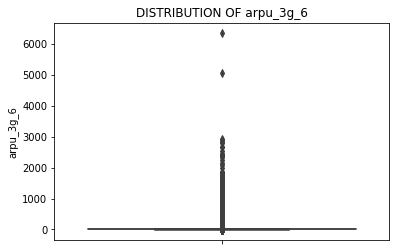

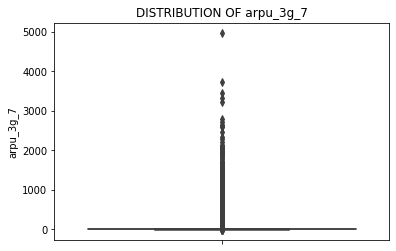

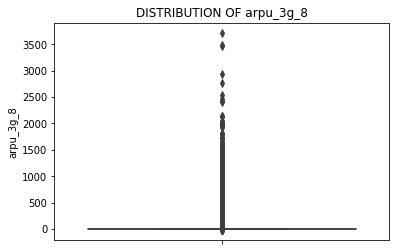

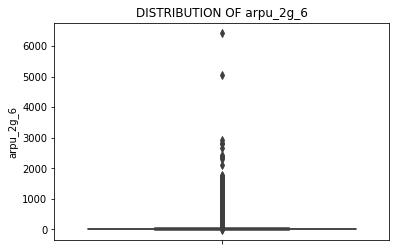

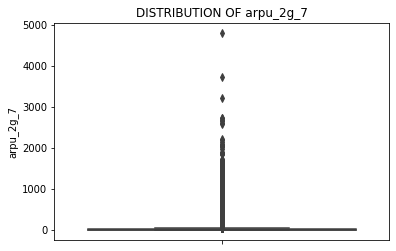

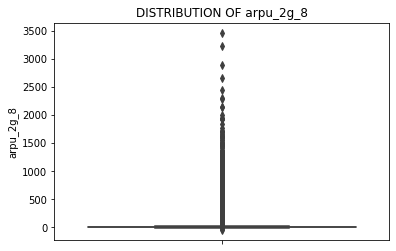

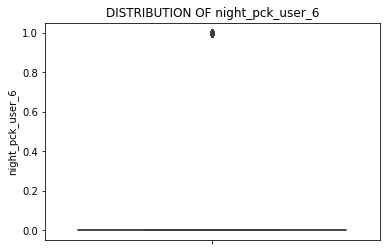

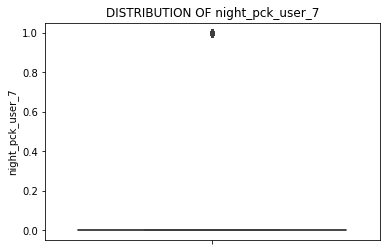

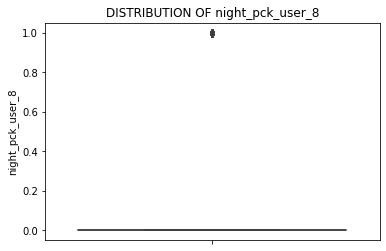

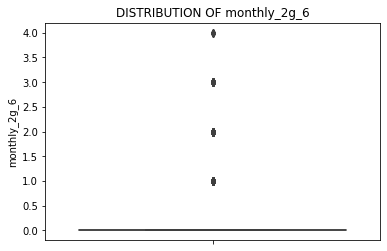

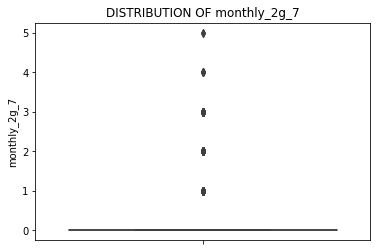

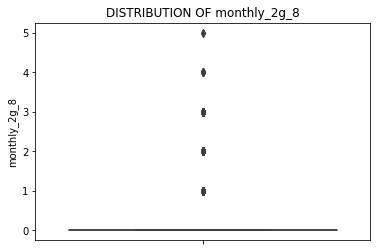

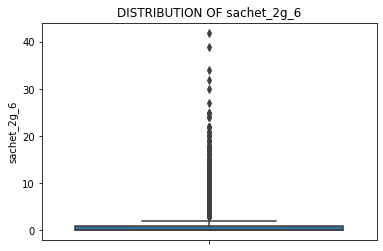

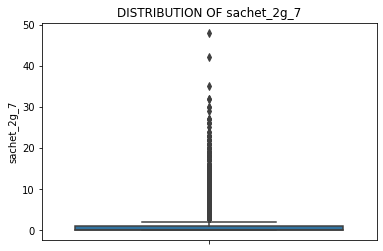

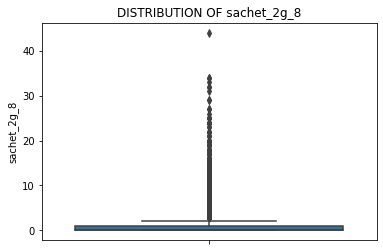

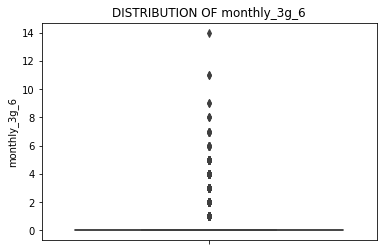

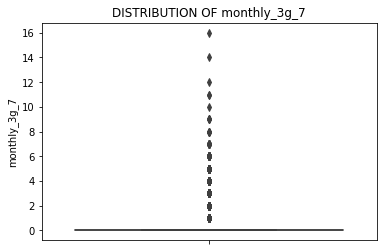

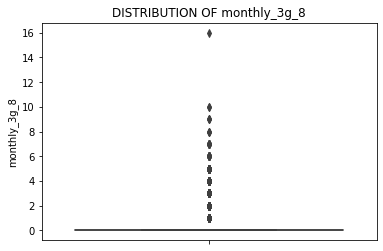

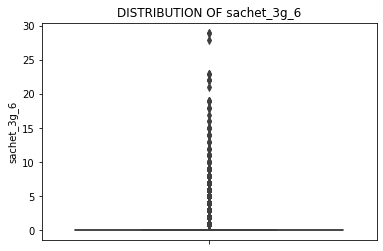

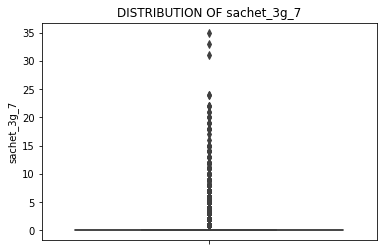

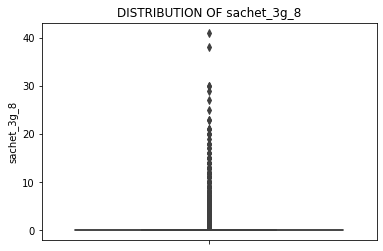

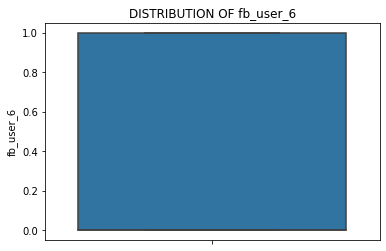

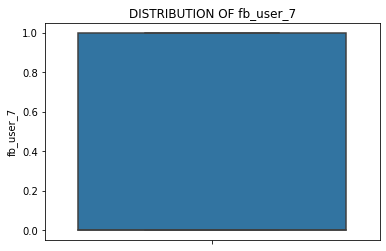

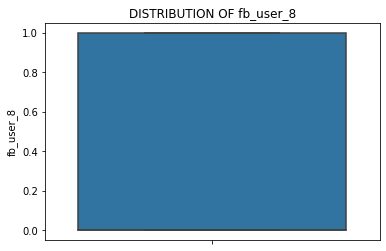

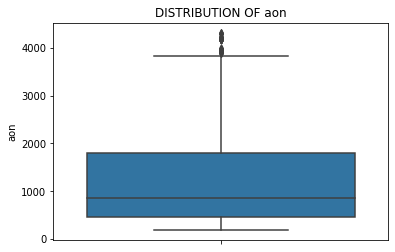

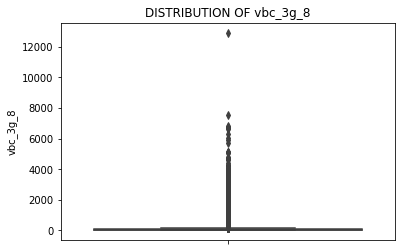

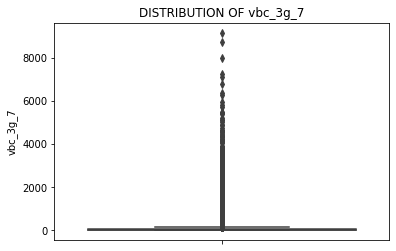

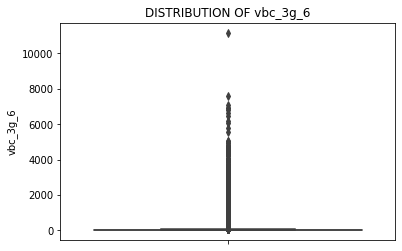

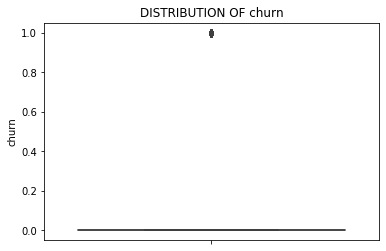

In [13]:
for numeric_variable in cleaned_data_df._get_numeric_data():
    plot_box(cleaned_data_df, numeric_variable)

# Deriving new features

In [14]:
df = cleaned_data_df

In [15]:
# average revenue per user 
df['arpu_2mths'] = (df['arpu_6']+df['arpu_7'])/2

In [16]:
df['arpu_4mths'] = (df['arpu_6']+df['arpu_7']+df['arpu_8'])/3

In [17]:
# age on network 
df['aon_years']=df['aon']/365
df['aon_years'] = df['aon_years'].astype(int)

In [18]:
# average revenue per user 
df['avg_tot_rech_2mths'] = (df['total_rech_amt_6']+df['total_rech_amt_7'])/2
df['avg_tot_rech_4mths'] = (df['total_rech_amt_6']+df['total_rech_amt_7']+df['total_rech_amt_8'])/3

In [19]:
def plot_for_seg_univariate(column_name,y_col_name,df_segment):
    plt.suptitle('UNIVARIATE ANALYSIS SEG (' + column_name + ')', fontsize=24)
    plt.rc("font", size=20)
    plt.figure(figsize=(15, 10))
    #my_colors = ['red','green','blue','black','yellow','pink','orange','purple','grey','brown']
    sns.barplot(x=df_segment.index, y=y_col_name, data=df_segment, palette="rocket" )
    plt.title('AGE V/S AVG REVENUE ' + column_name)
    plt.xlabel(column_name,rotation=0, fontsize=20, labelpad=20)
    plt.xticks(rotation=45,fontsize=10)
    plt.ylabel(' AGE V/S AVG REV  ',rotation=90, fontsize=20, labelpad=20)
    plt.show()
    return

In [20]:
def plot_by_grouped_barcharts(df_segment,label,showsize=10):
        colors = ['grey', 'black']
        ax=df_segment.plot(kind='bar',figsize=(15,10), color=colors)
        ax.set_xlabel(label, fontsize=12)
        ax.set_ylabel("CHURN", fontsize=12)
        plt.show()
        return 

In [21]:
def plot_by_segment_numbins(column,new_bin_col_name,y_col_name,binval,showsize=10):
        df[new_bin_col_name] = pd.cut(df[column], binval)
        df_num_column_status=df.pivot_table(values=[y_col_name],index=[new_bin_col_name],aggfunc='mean')
        df_num_column_status.head(showsize)
        return df_num_column_status

In [22]:
def create_bin(column,new_bin_col_name,binval):
    df[new_bin_col_name] = pd.cut(df[column], binval)
    return df

In [23]:
df2=plot_by_segment_numbins('aon_years','aon_group','arpu_2mths',10).sort_values(by='arpu_2mths',ascending=True)

In [24]:
print(df2)

               arpu_2mths
aon_group                
(-0.011, 1.1]  439.654086
(1.1, 2.2]     460.380101
(7.7, 8.8]     466.976204
(2.2, 3.3]     467.789644
(4.4, 5.5]     468.173834
(6.6, 7.7]     475.188550
(8.8, 9.9]     477.847590
(5.5, 6.6]     478.004476
(3.3, 4.4]     488.929814
(9.9, 11.0]    518.457708


<Figure size 432x288 with 0 Axes>

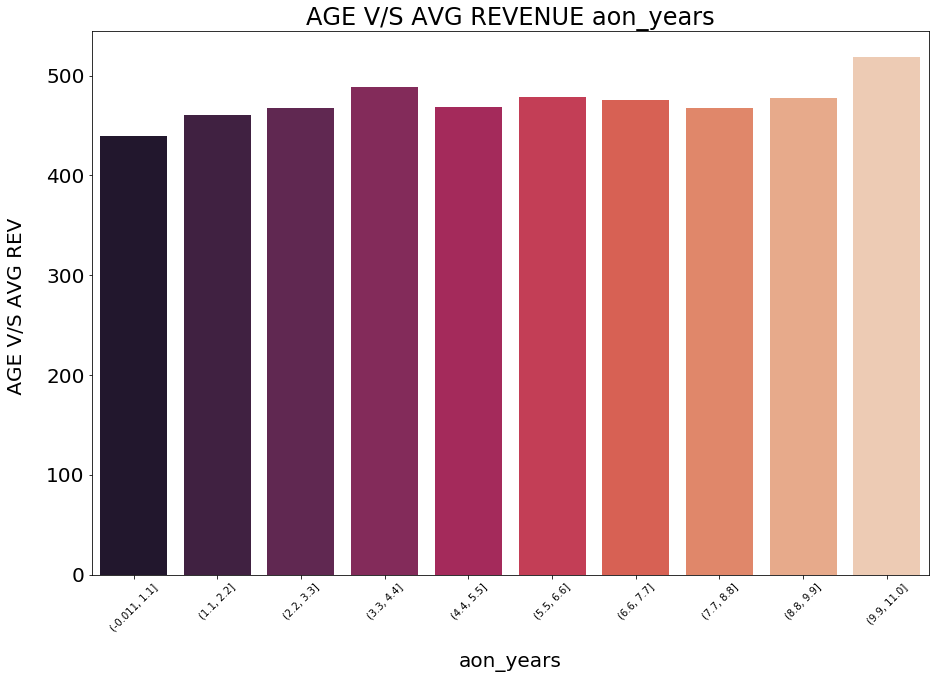

In [25]:
plot_for_seg_univariate('aon_years','arpu_2mths',df2)

In [26]:
df2=plot_by_segment_numbins('aon_years','aon_group','arpu_4mths',10).sort_values(by='arpu_4mths',ascending=True)
print(df2)

               arpu_4mths
aon_group                
(-0.011, 1.1]  430.352882
(1.1, 2.2]     450.958478
(2.2, 3.3]     459.083233
(7.7, 8.8]     464.936280
(4.4, 5.5]     464.983731
(6.6, 7.7]     472.194991
(5.5, 6.6]     476.657163
(8.8, 9.9]     477.482531
(3.3, 4.4]     484.194437
(9.9, 11.0]    519.527881


<Figure size 432x288 with 0 Axes>

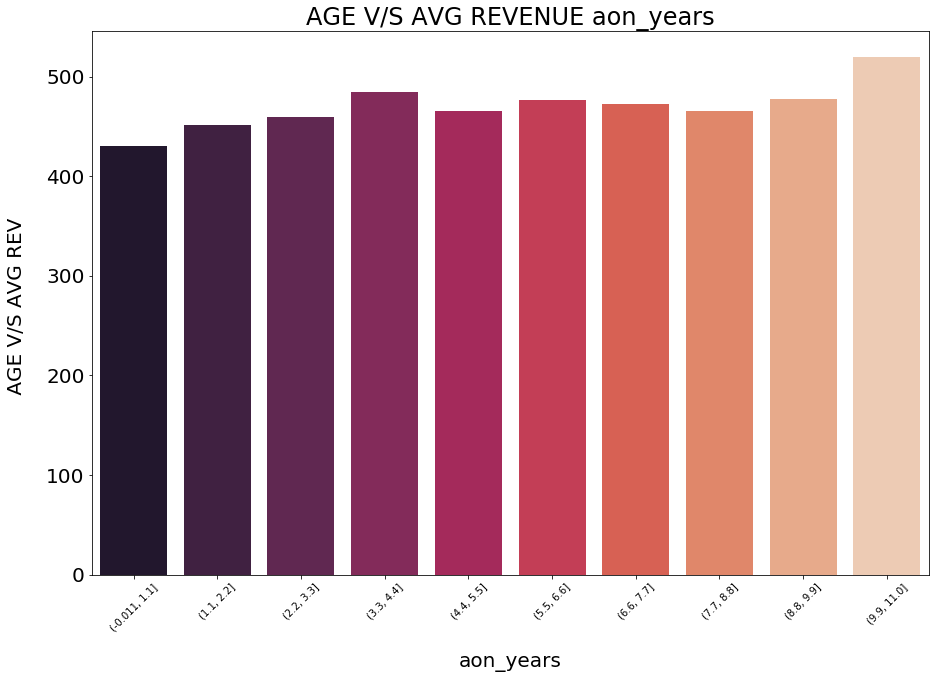

In [27]:
plot_for_seg_univariate('aon_years','arpu_4mths',df2)

In [28]:
df2=plot_by_segment_numbins('aon_years','aon_group','arpu_2mths',10).sort_values(by='arpu_2mths',ascending=True)
print(df2)

               arpu_2mths
aon_group                
(-0.011, 1.1]  439.654086
(1.1, 2.2]     460.380101
(7.7, 8.8]     466.976204
(2.2, 3.3]     467.789644
(4.4, 5.5]     468.173834
(6.6, 7.7]     475.188550
(8.8, 9.9]     477.847590
(5.5, 6.6]     478.004476
(3.3, 4.4]     488.929814
(9.9, 11.0]    518.457708


<Figure size 432x288 with 0 Axes>

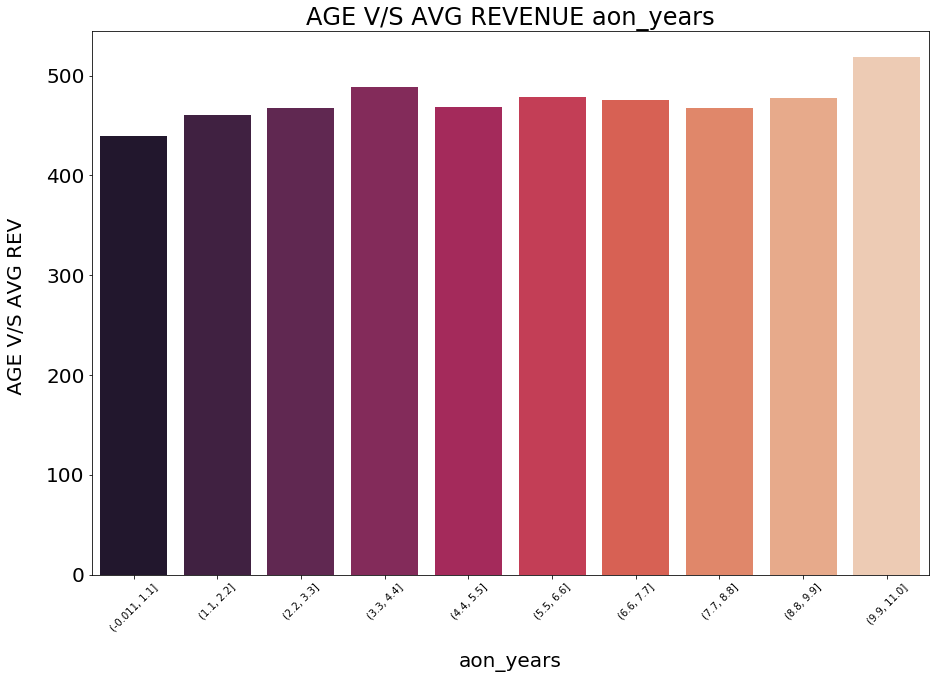

In [29]:
plot_for_seg_univariate('aon_years','arpu_2mths',df2)

In [30]:
def plotting_conti_var_BoxPlot(df,param):
    not_churned_df=df[df.churn == 0]
    churned_df=df[df.churn  == 1]
    plt.figure(figsize=(20, 10)) 
    plt.subplot(1,2,1)
    sns.boxplot(y=not_churned_df[param])
    plt.title(param +' DISTRIBUTION- NOT CHURNED ',fontsize=20) 
    plt.subplot(1,2,2)
    sns.boxplot(y=churned_df[param])
    plt.title(param +' DISTRIBUTION- NOT CHURNED ',fontsize=20)    
    plt.show()

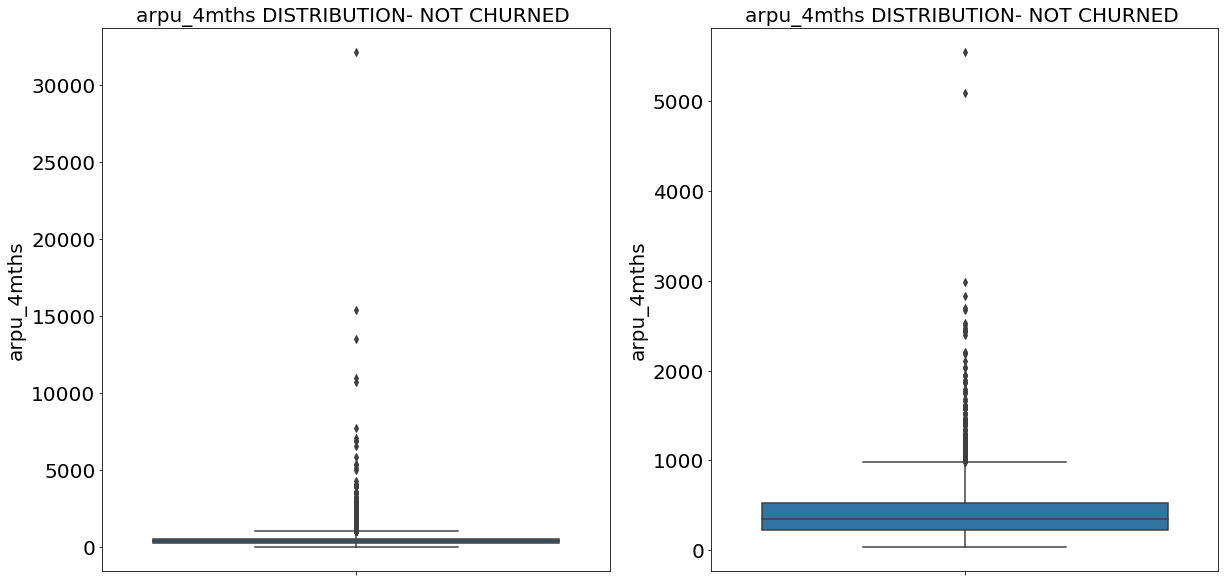

In [31]:
arpu_4df = df[['churn','arpu_4mths']]
plotting_conti_var_BoxPlot(arpu_4df,'arpu_4mths')

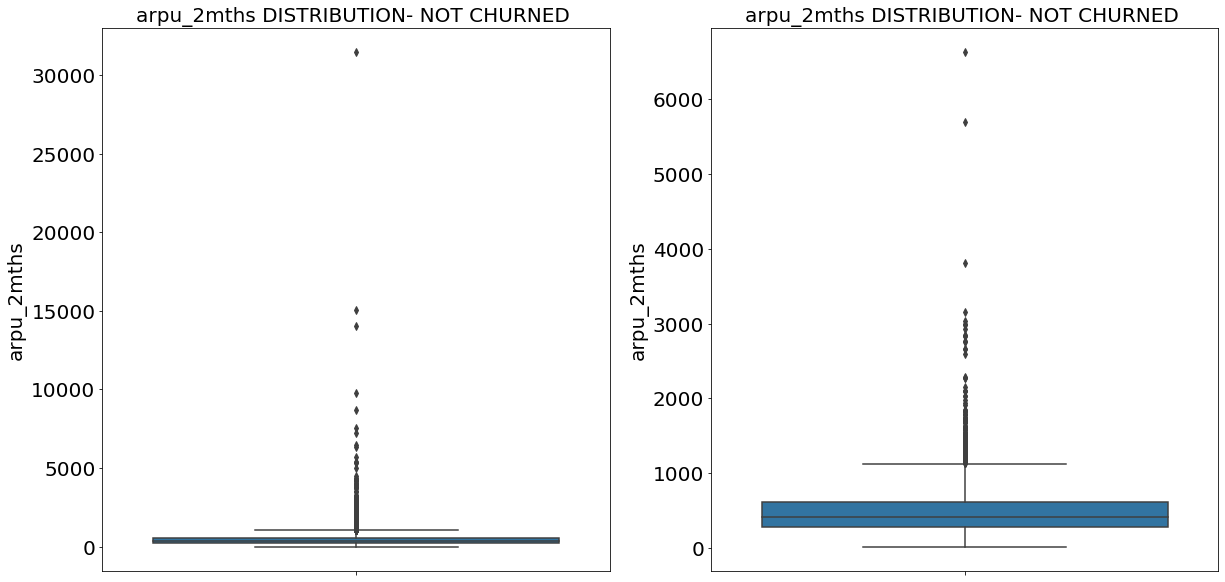

In [32]:
arpu_df = df[['churn','arpu_2mths']]
plotting_conti_var_BoxPlot(arpu_df,'arpu_2mths')

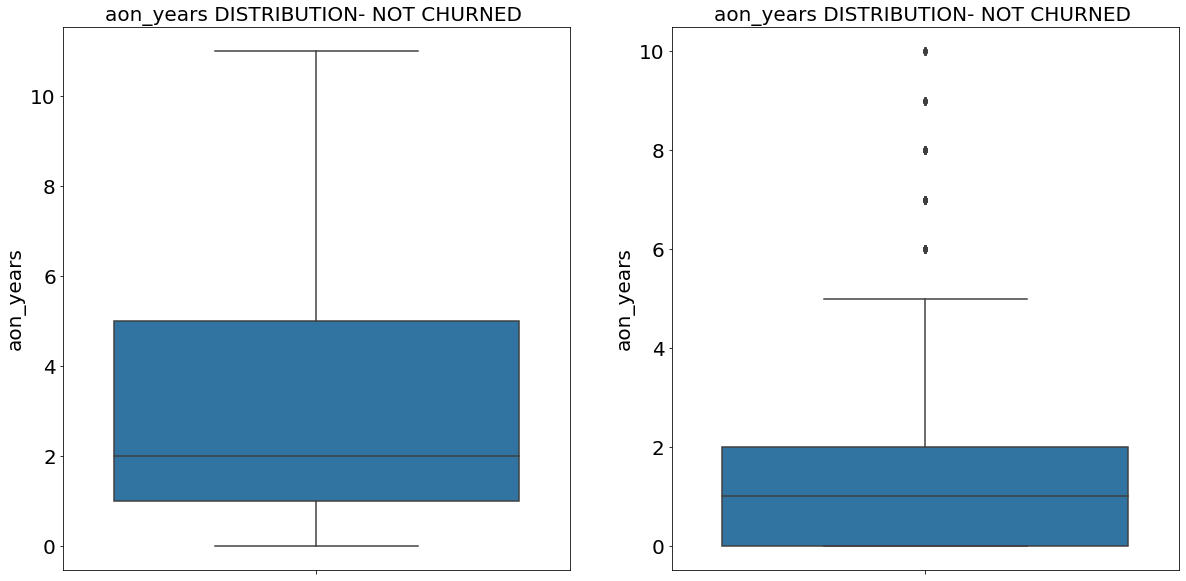

In [33]:
aon_df = df[['churn','aon_years']]
plotting_conti_var_BoxPlot(aon_df,'aon_years')

# checking counts of cols

In [34]:
df['aon_years'].value_counts()

1     11252
0      7551
2      6608
3      4299
6      2807
4      2644
7      2454
8      2132
5      1758
9       757
10      686
11       36
Name: aon_years, dtype: int64

In [35]:
df['churn'].value_counts()

0    40471
1     2513
Name: churn, dtype: int64

In [36]:
df_mod_1=pd.pivot_table(df, index='aon_group', columns=['churn'],values='aon', aggfunc='count')
print(df_mod_1)

churn              0     1
aon_group                 
(-0.011, 1.1]  17357  1446
(1.1, 2.2]      6130   478
(2.2, 3.3]      4093   206
(3.3, 4.4]      2550    94
(4.4, 5.5]      1698    60
(5.5, 6.6]      2726    81
(6.6, 7.7]      2384    70
(7.7, 8.8]      2086    46
(8.8, 9.9]       740    17
(9.9, 11.0]      707    15


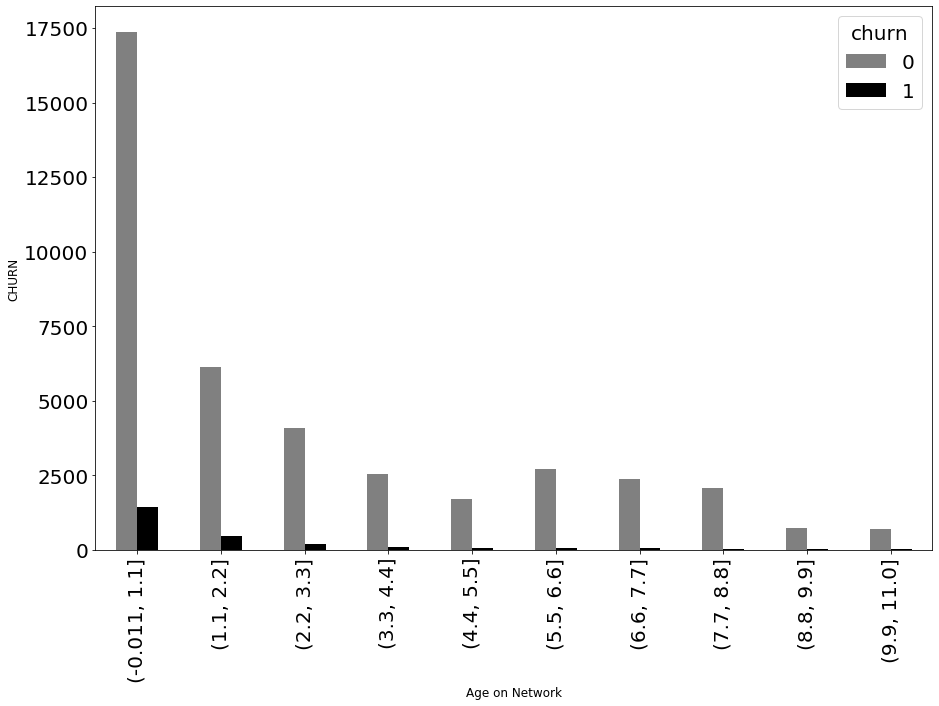

In [37]:
plot_by_grouped_barcharts(df_mod_1,'Age on Network')

In [38]:
#filling na with 0

In [39]:
df['churn'].fillna(0, inplace=True)

In [40]:
df=create_bin('arpu_2mths','arpu_group_2mths',10)
df_mod_1=pd.pivot_table(df, index='arpu_group_2mths', columns=['churn'],values='arpu_2mths', aggfunc = 'count',fill_value=0)
print(df_mod_1)

churn                       0     1
arpu_group_2mths                   
(-31.218, 3144.044]     40438  2509
(3144.044, 6287.868]       24     3
(6287.868, 9431.692]        5     1
(9431.692, 12575.516]       1     0
(12575.516, 15719.34]       2     0
(28294.637, 31438.461]      1     0


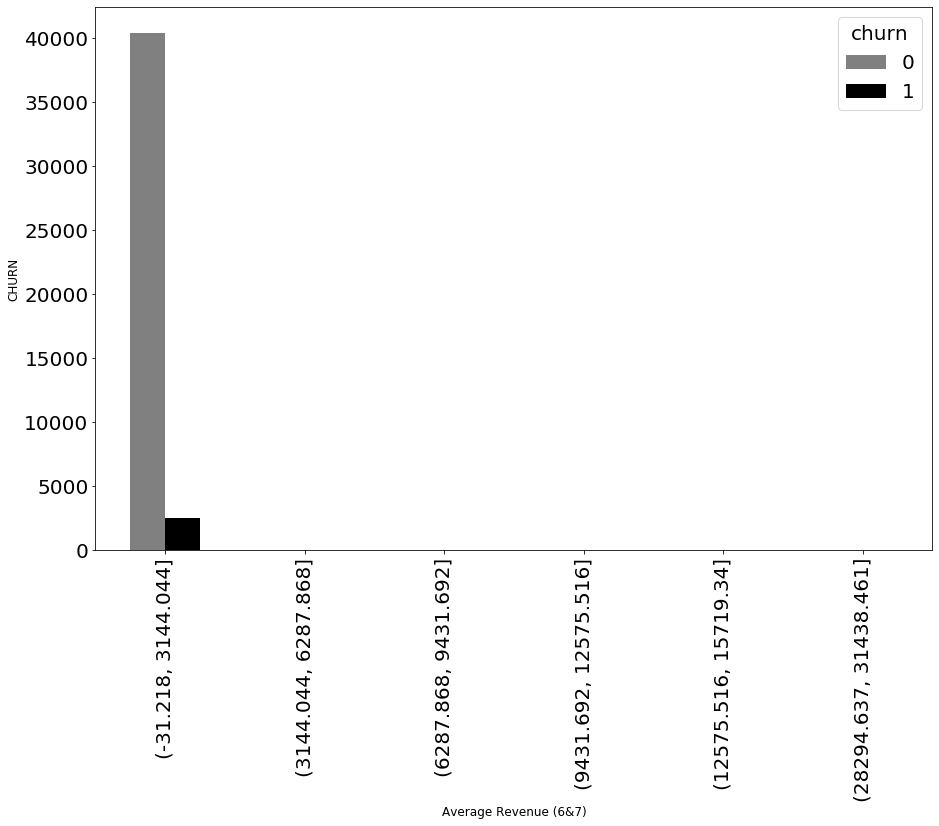

In [41]:
plot_by_grouped_barcharts(df_mod_1,'Average Revenue (6&7)')

In [42]:
df=create_bin('arpu_4mths','arpu_group_4mths',5)
df_mod_1=pd.pivot_table(df, index='arpu_group_4mths', columns=['churn'],values='arpu_4mths', aggfunc = 'count',fill_value=0)
print(df_mod_1)

churn                       0     1
arpu_group_4mths                   
(7.951, 6460.077]       40461  2513
(6460.077, 12880.103]       7     0
(12880.103, 19300.129]      2     0
(25720.156, 32140.182]      1     0


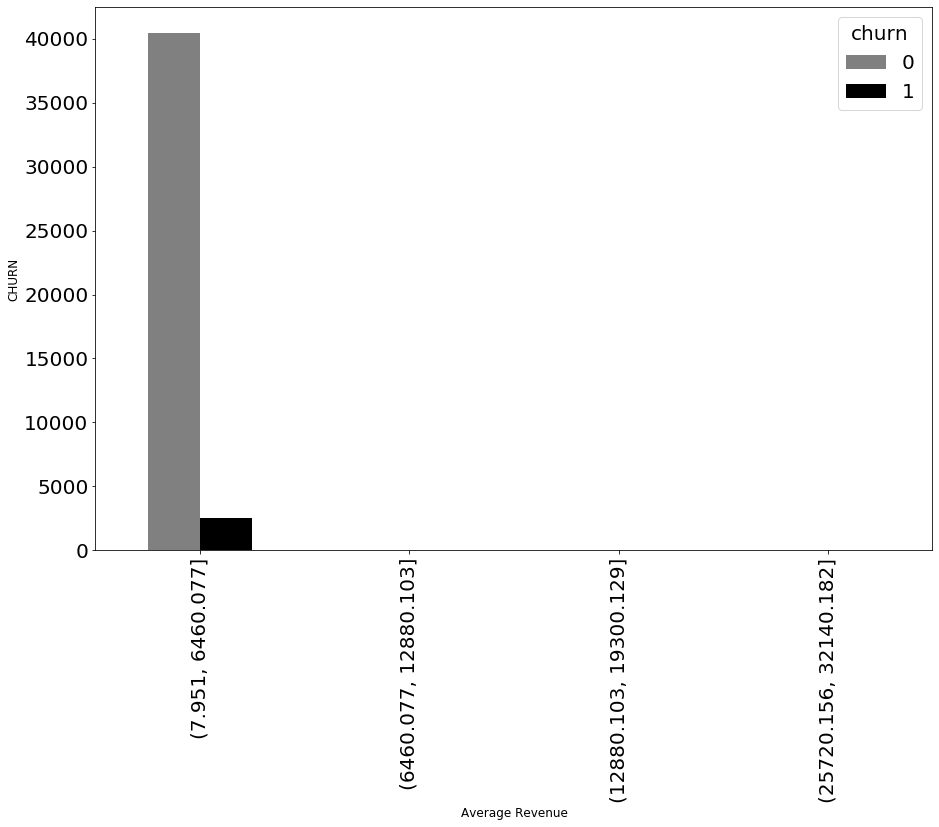

In [43]:
plot_by_grouped_barcharts(df_mod_1,'Average Revenue')

In [44]:
df['avg_max_rech_amt']=(df['max_rech_amt_6']+df['max_rech_amt_7'])/2
df=create_bin('avg_max_rech_amt','max_rech_amt_group_2mths',3)
df_mod_1=pd.pivot_table(df, index='max_rech_amt_group_2mths', columns=['churn'],values='avg_max_rech_amt', aggfunc = 'count',fill_value=0)
print(df_mod_1)

churn                         0     1
max_rech_amt_group_2mths             
(-3.1, 1033.333]          40382  2499
(1033.333, 2066.667]         83    12
(2066.667, 3100.0]            6     2


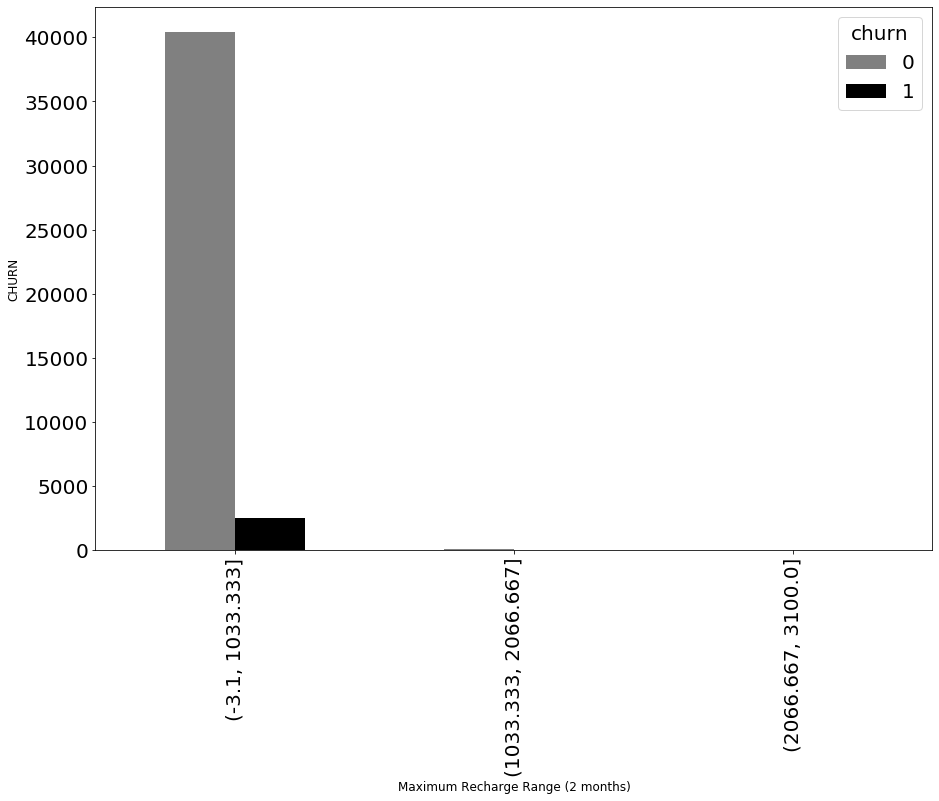

In [45]:
plot_by_grouped_barcharts(df_mod_1,'Maximum Recharge Range (2 months)')

In [46]:
df['avg_total_rech_amt']=(df['total_rech_amt_6']+df['total_rech_amt_7'])/2
df=create_bin('avg_total_rech_amt','total_rech_amt_group_2mths',5)
df_mod_1=pd.pivot_table(df, index='total_rech_amt_group_2mths', columns=['churn'],values='avg_total_rech_amt', aggfunc = 'count',fill_value=0)
print(df_mod_1)

churn                           0     1
total_rech_amt_group_2mths             
(-37.762, 7552.5]           40464  2511
(7552.5, 15105.0]               3     2
(15105.0, 22657.5]              3     0
(30210.0, 37762.5]              1     0


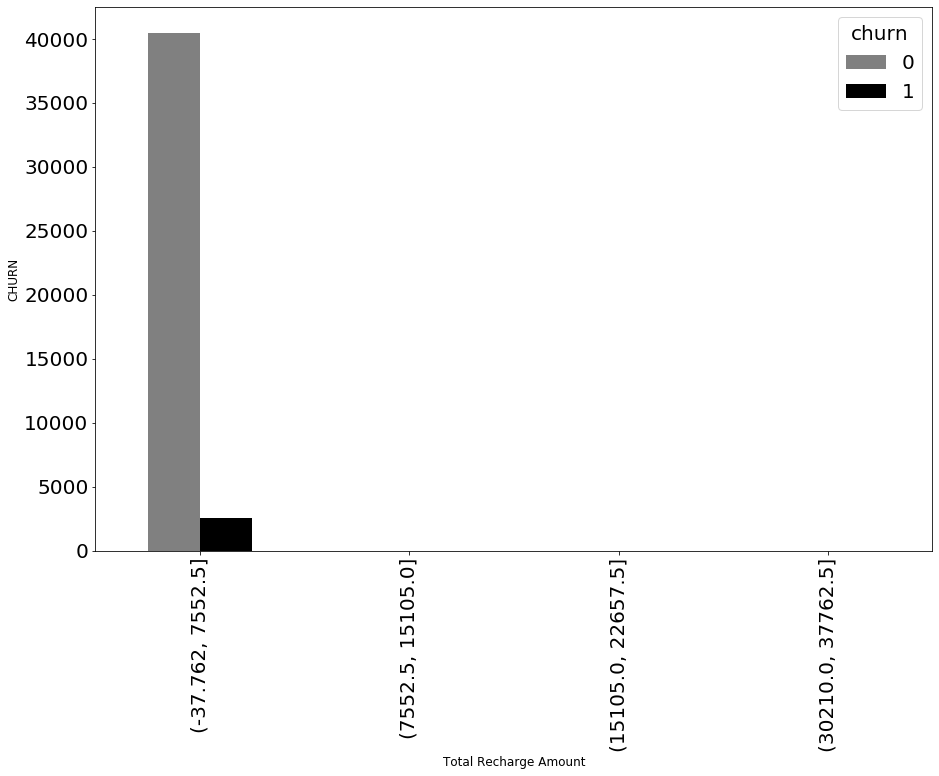

In [47]:
plot_by_grouped_barcharts(df_mod_1,'Total Recharge Amount')

# Bivariate Analysis

In [48]:
df.select_dtypes(exclude=['object'])

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
0         7000842753   197.385   214.816   213.803         0.00         0.00   
1         7001865778    34.047   355.074   268.321        24.11        78.68   
2         7000142493   261.636   309.876   238.174        50.31       149.44   
3         7000701601  1069.180  1349.850  3171.480        57.84        54.68   
4         7001524846   378.721   492.223   137.362       413.69       351.03   
...              ...       ...       ...       ...          ...          ...   
46547     7000630859   384.316   255.405   393.474        78.68        29.04   
46549     7000661676   328.594   202.966   118.707       423.99       181.83   
46550     7001729035   644.973   455.228   564.334       806.73       549.36   
46551     7002111859   312.558   512.932   402.080       199.89       174.46   
46554     7000498689   322.991   303.386   606.817         0.00         0.00   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  aon_years  \
0             0.00          0.00          0.00          0.00  ...          2   
1             7.68         15.74         99.84        304.76  ...          2   
2            83.89         76.96         91.88        124.26  ...          4   
3            52.29        453.43        567.16        325.91  ...          2   
4            35.08         94.66         80.63        136.48  ...          0   
...            ...           ...           ...           ...  ...        ...   
46547       103.24         56.13         28.09         61.44  ...          1   
46549         5.71         39.51         39.81         18.26  ...          2   
46550       775.41        784.76        617.13        595.44  ...          7   
46551         2.46        175.88        277.01        248.33  ...          0   
46554         0.00          0.00          0.00          0.00  ...          1   

       avg_tot_rech_2mths  avg_tot_rech_4mths      aon_group  \
0                   307.0          288.666667     (1.1, 2.2]   
1                   229.0          247.000000     (1.1, 2.2]   
2                   273.0          277.666667     (3.3, 4.4]   
3                  1185.0         2002.666667     (1.1, 2.2]   
4                   519.0          386.000000  (-0.011, 1.1]   
...                   ...                 ...            ...   
46547               312.0          378.666667  (-0.011, 1.1]   
46549               299.5          245.333333     (1.1, 2.2]   
46550               848.5          574.000000     (6.6, 7.7]   
46551               467.0          479.333333  (-0.011, 1.1]   
46554               369.5          485.000000  (-0.011, 1.1]   

          arpu_group_2mths   arpu_group_4mths  avg_max_rech_amt  \
0      (-31.218, 3144.044]  (7.951, 6460.077]             252.0   
1      (-31.218, 3144.044]  (7.951, 6460.077]              99.0   
2      (-31.218, 3144.044]  (7.951, 6460.077]              83.0   
3      (-31.218, 3144.044]  (7.951, 6460.077]            1185.0   
4      (-31.218, 3144.044]  (7.951, 6460.077]             122.0   
...                    ...                ...               ...   
46547  (-31.218, 3144.044]  (7.951, 6460.077]             252.0   
46549  (-31.218, 3144.044]  (7.951, 6460.077]             100.0   
46550  (-31.218, 3144.044]  (7.951, 6460.077]             668.0   
46551  (-31.218, 3144.044]  (7.951, 6460.077]             102.0   
46554  (-31.218, 3144.044]  (7.951, 6460.077]             190.5   

       max_rech_amt_group_2mths  avg_total_rech_amt  \
0              (-3.1, 1033.333]               307.0   
1              (-3.1, 1033.333]               229.0   
2              (-3.1, 1033.333]               273.0   
3          (1033.333, 2066.667]              1185.0   
4              (-3.1, 1033.333]               519.0   
...                         ...                 ...   
46547          (-3.1, 1033.333]               312.0   
46549          (-3.1, 1033.333]               299.5   
46550          (

# correlation matrix 

No handles with labels found to put in legend.


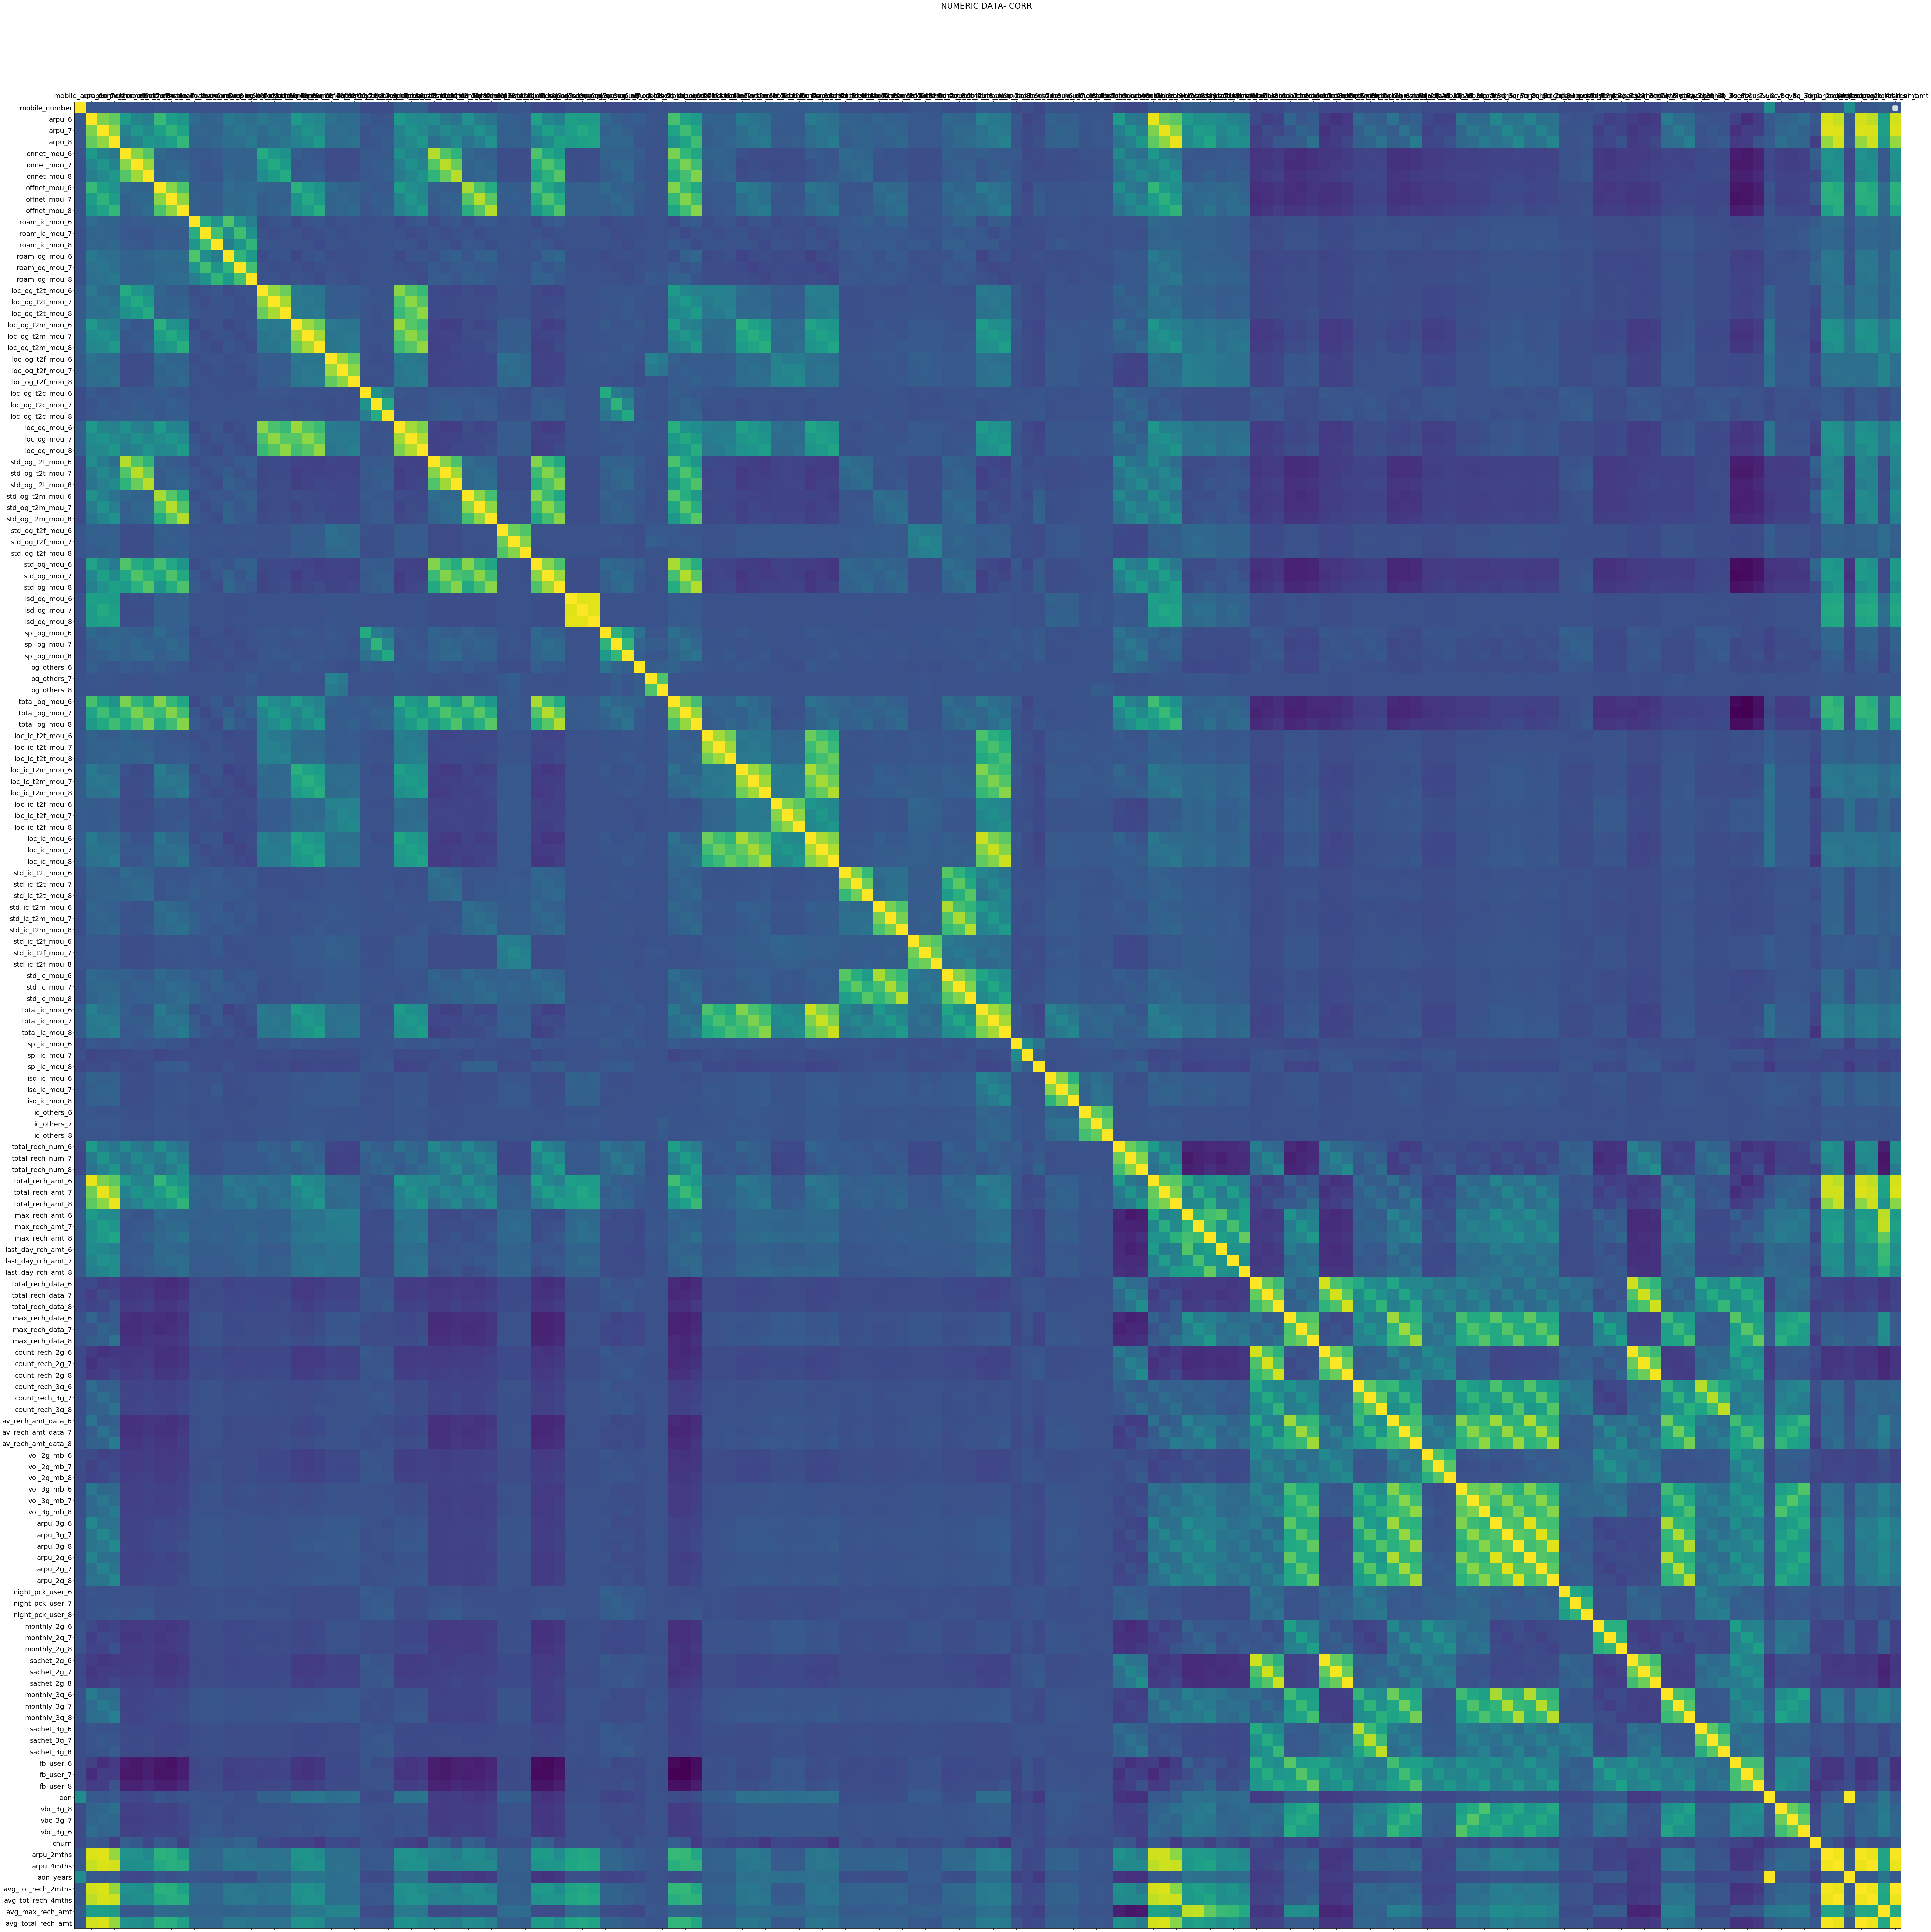

In [49]:
upper = df._get_numeric_data().corr()
fig, ax = plt.subplots(figsize=(100, 100))
ax.matshow(upper)
plt.xticks(range(len(upper.columns)), upper.columns)
plt.yticks(range(len(upper.columns)), upper.columns)
ax.legend()
plt.title('NUMERIC DATA- CORR ')
plt.show()

# Building & Evaluating Model 

In [50]:
cleaned_data_df = ( Data_cleaner()
    .import_data()
    .dropping_single_col()
    .fill_na()
    .filtering_high_val_cust()
    .fixing_col_names()
    .tagging_churner()
    .removing_neg_arpu() 
    .imputing_night_pack_user()       
    .imputing_fb_user()  
    ).df

# PCA

## Data Preparation for categorical variable

In [51]:
PCA_df=df._get_numeric_data()

# importing lib

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X = PCA_df.drop(['churn','mobile_number'],axis=1)
y = PCA_df['churn']

In [54]:
y.head()

0    1
1    0
2    0
3    1
4    0
Name: churn, dtype: int32

# IMOORTING LIBRARIES

# STANDARDIZING DATA

In [55]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)
Scaled_Xtrain=sc.fit_transform(X_train,y_train)
X_scaler = sc.fit_transform(X_train,y_train)

# Splitting training and test data

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

# CHECKING IMBALANCE

In [58]:
y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("TRAIN DATA IMBALANCE : ", y_train_imb)
print("TEST DATA IMBALANCE : ", y_test_imb)

TRAIN DATA IMBALANCE :  0.06156723000388103
TEST DATA IMBALANCE :  0.0633245382585752


In [59]:
# Balancing DataSet
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)

C:\Users\Farzana\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Farzana\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Farzana\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be remo

In [60]:
print("X_tr SHAPE::", X_tr.shape)
print("y_tr SHAPE::", y_tr.shape)
imb = (y_tr != 0).sum()/(y_tr == 0).sum()
print("TRAIN DATA IMBALANCE : : ",imb)

X_tr SHAPE:: (56686, 158)
y_tr SHAPE:: (56686,)
TRAIN DATA IMBALANCE : :  1.0


# building lin reg

In [61]:
from sklearn.linear_model import LinearRegression

In [62]:
lr = LinearRegression()

# Fittimg  the model 

In [63]:
lr.fit(Scaled_Xtrain, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
X_test_scaler = sc.fit_transform(X_test,y_test)
Scaled_Xtest=sc.fit_transform(X_test,y_test)

In [65]:
y_pred = lr.predict(Scaled_Xtest)

In [66]:
y_test.unique()

array([0, 1])

# building lin reg

In [67]:
from sklearn.metrics import mean_squared_error, r2_score

# mean_squared_error

In [68]:
mse = mean_squared_error(y_test, y_pred)
print(mse)

3.379063712447368e+17


# r square score

In [69]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

-6.033315286662979e+18


# checking shape

In [70]:
Scaled_Xtrain.shape

(30088, 158)

# IMPORTING PCA

In [71]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=100)

In [72]:
#PCA FITTING

In [73]:
pca.fit(Scaled_Xtrain)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='randomized', tol=0.0, whiten=False)

In [74]:
# CHECKING COMPONENTS

In [75]:
pca.components_

array([[ 1.84452993e-01,  1.89464481e-01,  1.78609800e-01, ...,
         2.01018643e-01,  1.07715947e-01,  1.99102729e-01],
       [ 2.80842031e-02,  2.81340198e-02,  3.55015428e-02, ...,
         3.16446762e-02,  8.98043115e-02,  2.73253144e-02],
       [ 5.84915570e-02,  7.50052815e-02,  6.18407877e-02, ...,
         7.16965638e-02, -3.68219165e-02,  7.12180862e-02],
       ...,
       [-0.00000000e+00, -3.56115363e-16, -1.67904553e-02, ...,
         6.84103483e-02,  2.71707815e-01,  1.19208481e-02],
       [-0.00000000e+00,  2.10279268e-17,  7.65765848e-09, ...,
        -5.80526529e-08, -6.90148963e-07, -7.07106777e-01],
       [-4.55219978e-01, -4.86823553e-01, -1.41180060e-01, ...,
        -1.05427819e-15, -6.94973593e-16,  2.94902991e-16]])

In [76]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})

In [77]:
pcs_df.head()

PC1       PC2      Feature
0  0.184453  0.028084       arpu_6
1  0.189464  0.028134       arpu_7
2  0.178610  0.035502       arpu_8
3  0.098941 -0.068419  onnet_mou_6
4  0.104193 -0.073000  onnet_mou_7

In [78]:
# CHECKING VARIANCE RATIO

In [79]:
pca.explained_variance_ratio_

array([1.21792042e-01, 1.03599564e-01, 6.51231450e-02, 5.13655853e-02,
       3.81370964e-02, 3.57229612e-02, 2.70938513e-02, 2.53442568e-02,
       2.37994947e-02, 2.13703943e-02, 2.02865849e-02, 1.78946777e-02,
       1.76540887e-02, 1.72999685e-02, 1.68121525e-02, 1.65629116e-02,
       1.51690214e-02, 1.40998663e-02, 1.30653220e-02, 1.25222754e-02,
       1.23112412e-02, 1.22302166e-02, 1.16960483e-02, 1.08173821e-02,
       1.05169270e-02, 1.02648705e-02, 9.50745128e-03, 8.69490589e-03,
       7.89008710e-03, 7.78669374e-03, 7.41960203e-03, 7.23928753e-03,
       6.90675367e-03, 6.74609834e-03, 6.71640167e-03, 6.34696175e-03,
       6.03520748e-03, 5.95185486e-03, 5.87695266e-03, 5.57236570e-03,
       5.40954679e-03, 5.20631691e-03, 5.15698763e-03, 4.97053944e-03,
       4.79078949e-03, 4.73822871e-03, 4.54156030e-03, 4.43072294e-03,
       4.25034990e-03, 4.13897172e-03, 4.07448033e-03, 3.80865866e-03,
       3.63842731e-03, 3.55046414e-03, 3.45453077e-03, 3.26059365e-03,
      

# SCREENPLOT OF CUMULATIVE VARIANCE V/S VARIANCE RATIO

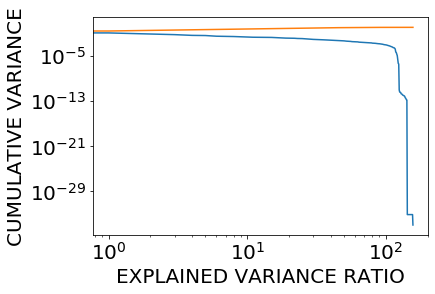

In [80]:
plt.yscale('log')
plt.xscale('log')
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('EXPLAINED VARIANCE RATIO')
plt.ylabel('CUMULATIVE VARIANCE')
plt.show()

# SCREENPLOT OF CUMULATIVE VARIANCE V/S NO OF COMPONENTS

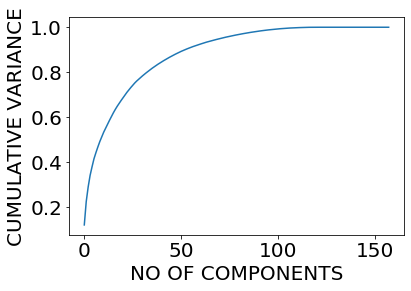

In [81]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('NO OF COMPONENTS')
plt.ylabel('CUMULATIVE VARIANCE')
plt.show()

# IMPORTING INCREMENTAL PCA FROM SKLEARN

In [82]:
from sklearn.decomposition import IncrementalPCA

In [83]:
pca_final = IncrementalPCA(n_components=82)

In [84]:
# FITTING DATA

In [85]:
df_train_pca = pca_final.fit_transform(Scaled_Xtrain)
df_train_pca.shape

(30088, 82)

# CORRELATION MATRIX (PCA)

In [86]:
corr_mat = np.corrcoef(df_train_pca.transpose())

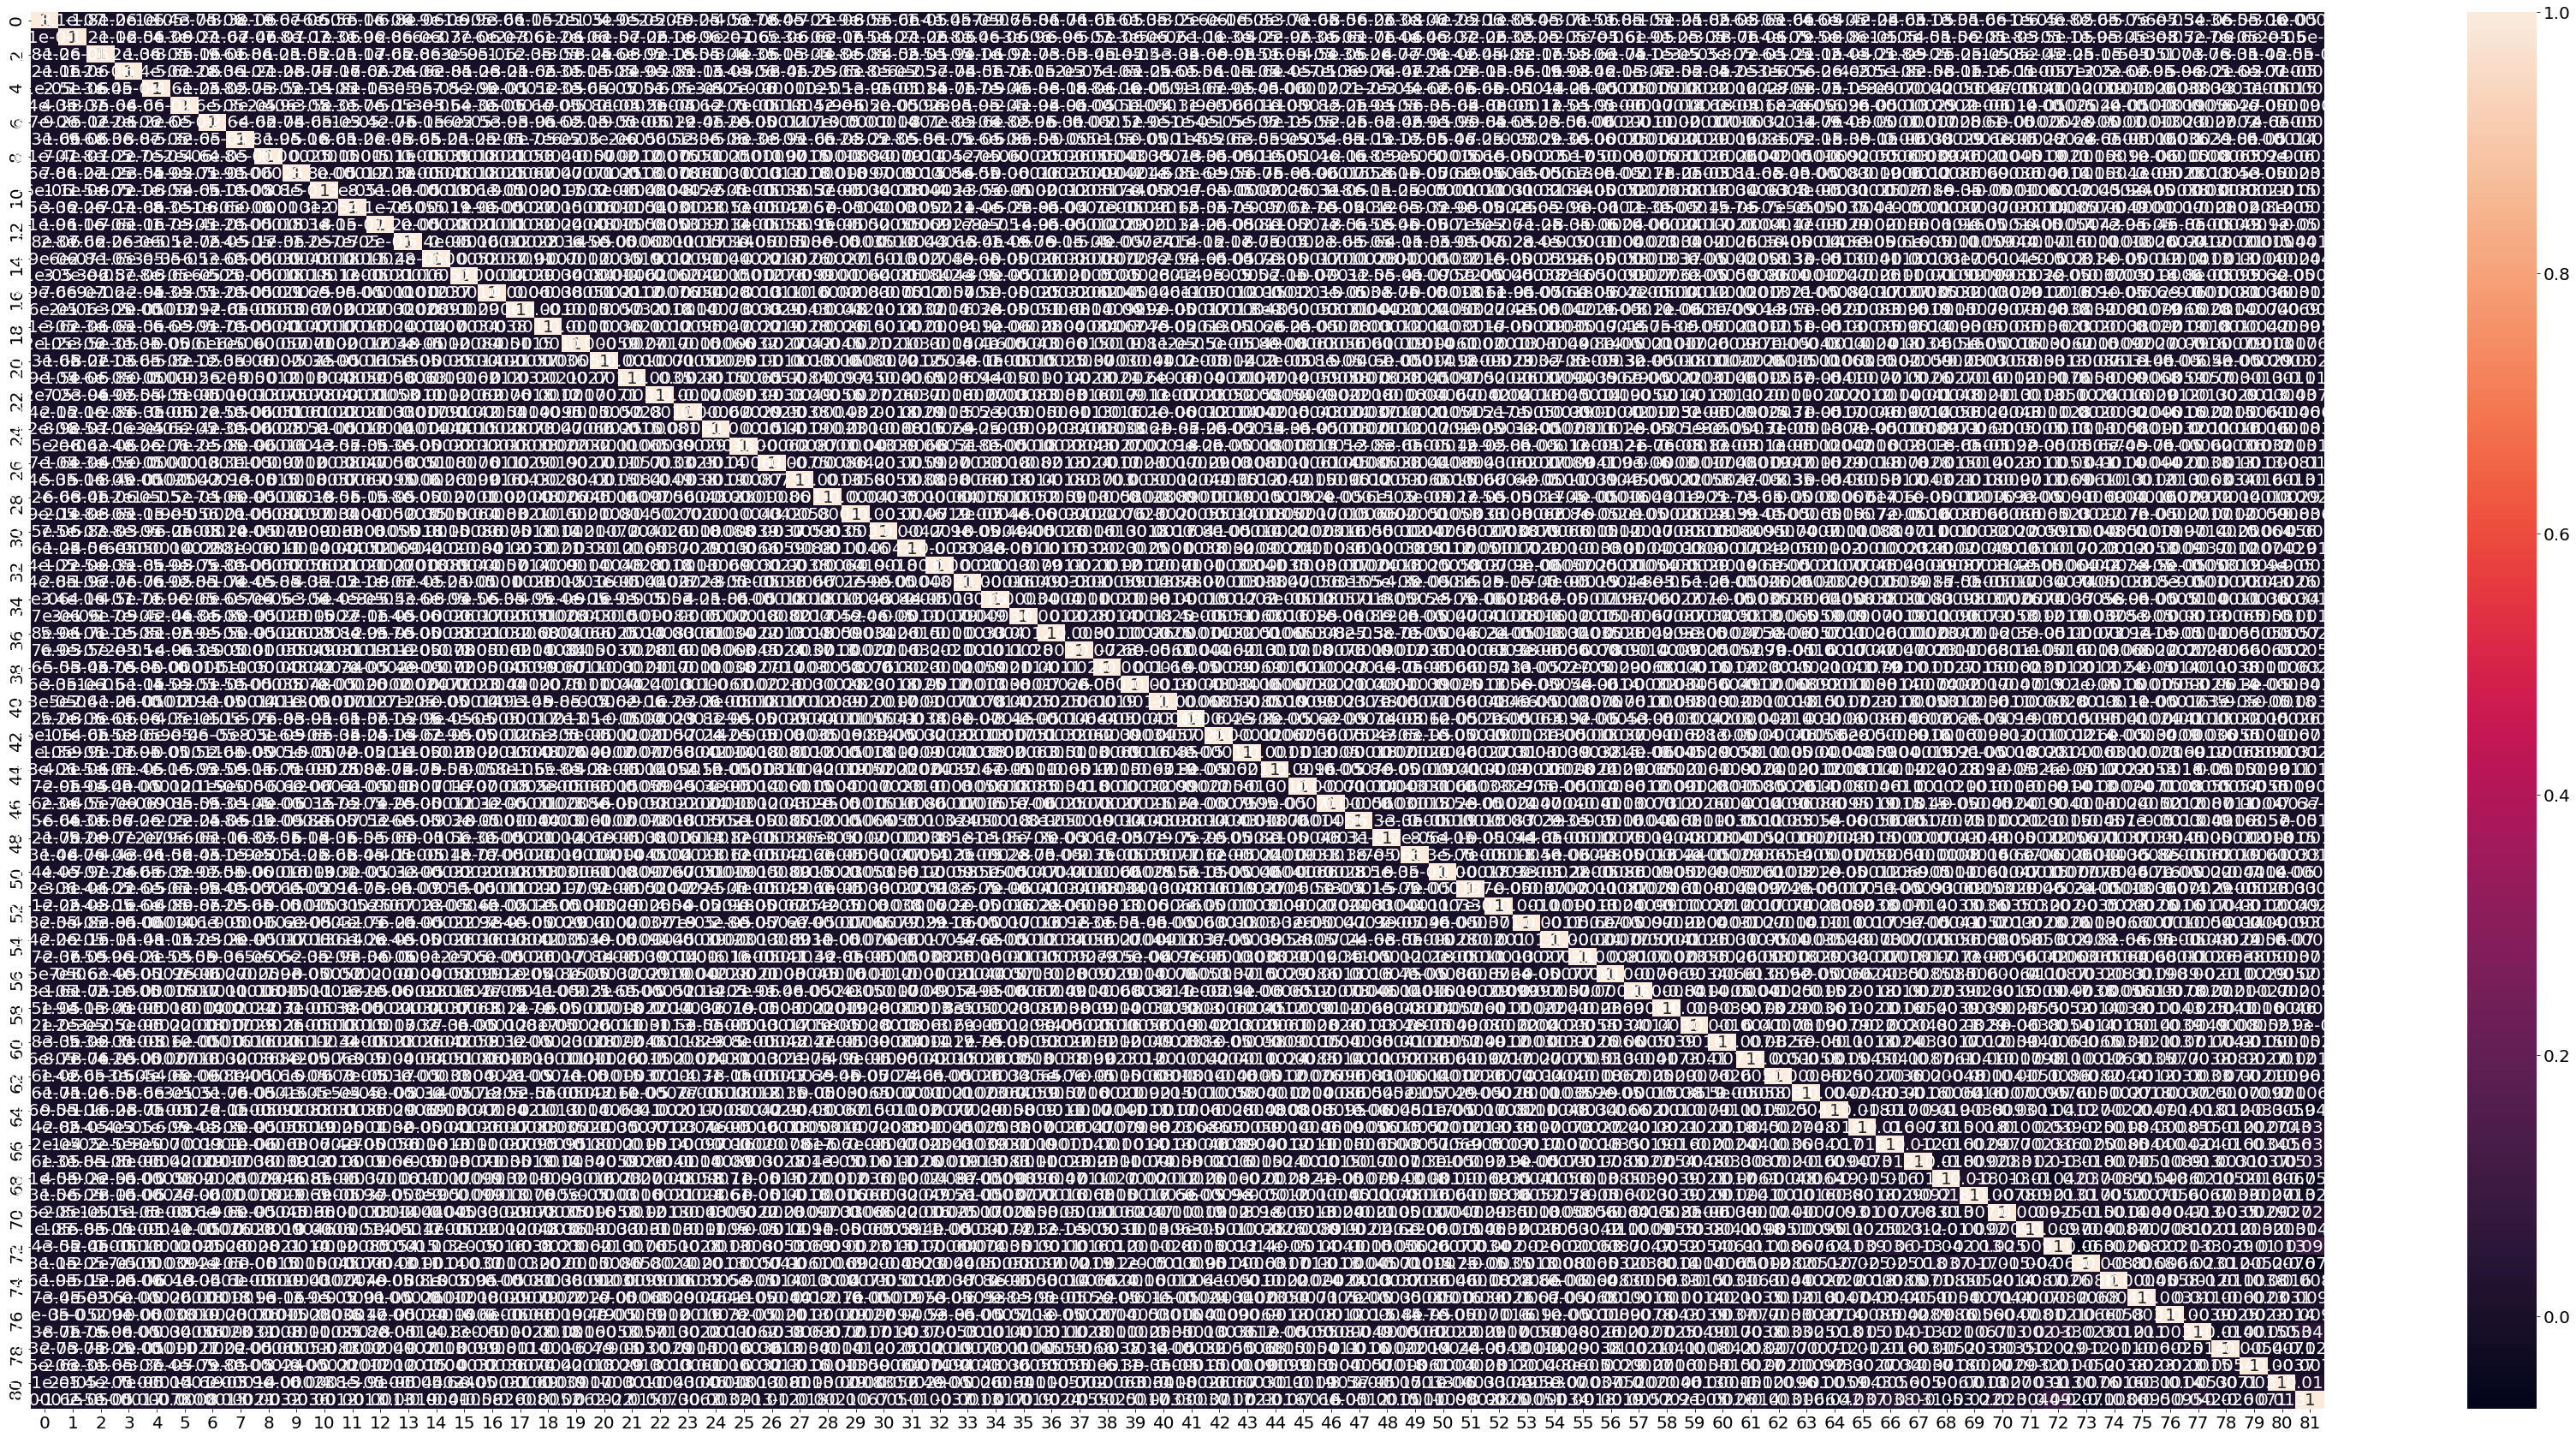

In [87]:
#plotting the correlation matrix
plt.figure(figsize = (60,30))
sns.heatmap(corr_mat,annot = True)

# CHECKING MAX AND MIN CORRELATION


In [88]:
corr_mat_nodiag = corr_mat - np.diagflat(corr_mat.diagonal())
print("MAX CORR:",corr_mat_nodiag.max(), ", MIN CORR: ", corr_mat_nodiag.min(),)

MAX CORR: 0.09236292150756038 , MIN CORR:  -0.07099231463684252


In [89]:
#Applying selected components to the test data

In [90]:
df_test_pca = pca_final.transform(Scaled_Xtest)
df_test_pca.shape

(12896, 82)

# TRAINING MODEL

In [91]:
# IMPORTING LIBRARIES

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [93]:
pca_learner = LinearRegression()
pca_model = pca_learner.fit(df_train_pca,y_train)

In [94]:
y_predict_pca = pca_model.predict(df_test_pca)

# CALCULATING MSE

In [95]:
from sklearn.metrics import mean_squared_error, r2_score

In [96]:
mse = mean_squared_error(y_test, y_predict_pca)
mse

0.05040221599358319

In [97]:
pca_2 = PCA(n_components=82,random_state=100)

In [98]:
# PREPPING TRAIN DATA

In [99]:
df_train_pca = pca_2.fit_transform(Scaled_Xtrain)
df_train_pca.shape

(30088, 82)

In [100]:
#CHECING ON COMPONENTS OF TEST DATA

In [101]:
df_test_pca = pca_2.fit_transform(Scaled_Xtest)
df_test_pca.shape

(12896, 82)

# TRAINING MODEL

In [102]:
# IMPORTING LIBRARIES

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [104]:
pca_learner = LinearRegression()
pca_model = pca_model.fit(df_train_pca,y_train)

In [105]:
y_predict_pca = pca_model.predict(df_test_pca)

In [106]:
from sklearn.metrics import mean_squared_error, r2_score

In [107]:
mse = mean_squared_error(y_test, y_predict_pca)
mse

0.058638601485675484

In [108]:
y_predict_pca

array([ 0.10252098,  0.03350432, -0.01151969, ...,  0.0529094 ,
        0.01846157,  0.00291065])

# CALCULATING ROOT MEAN SQUARE ERROR

In [109]:
import numpy as np
from sklearn import metrics
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_predict_pca)))

RMSE : 0.24215408624608317


# CONCATINATING COMPONENTS

In [110]:
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'PC4':pca.components_[3],'Feature':colnames})
pcs_df

PC1       PC2       PC3       PC4             Feature
0    0.184453  0.028084  0.058492  0.000789              arpu_6
1    0.189464  0.028134  0.075005  0.003487              arpu_7
2    0.178610  0.035502  0.061841  0.011721              arpu_8
3    0.098941 -0.068419  0.073995  0.028552         onnet_mou_6
4    0.104193 -0.073000  0.088751  0.031621         onnet_mou_7
..        ...       ...       ...       ...                 ...
153  0.024986  0.014906 -0.097704 -0.042976           aon_years
154  0.199103  0.027325  0.071218 -0.002147  avg_tot_rech_2mths
155  0.201019  0.031645  0.071697  0.003470  avg_tot_rech_4mths
156  0.107716  0.089804 -0.036822 -0.126293    avg_max_rech_amt
157  0.199103  0.027325  0.071218 -0.002147  avg_total_rech_amt

[158 rows x 5 columns]

# CHECKING LENGTH

In [111]:
len(pcs_df.Feature)    

158

# PLOTTING COMPONENT 1 V/S 2

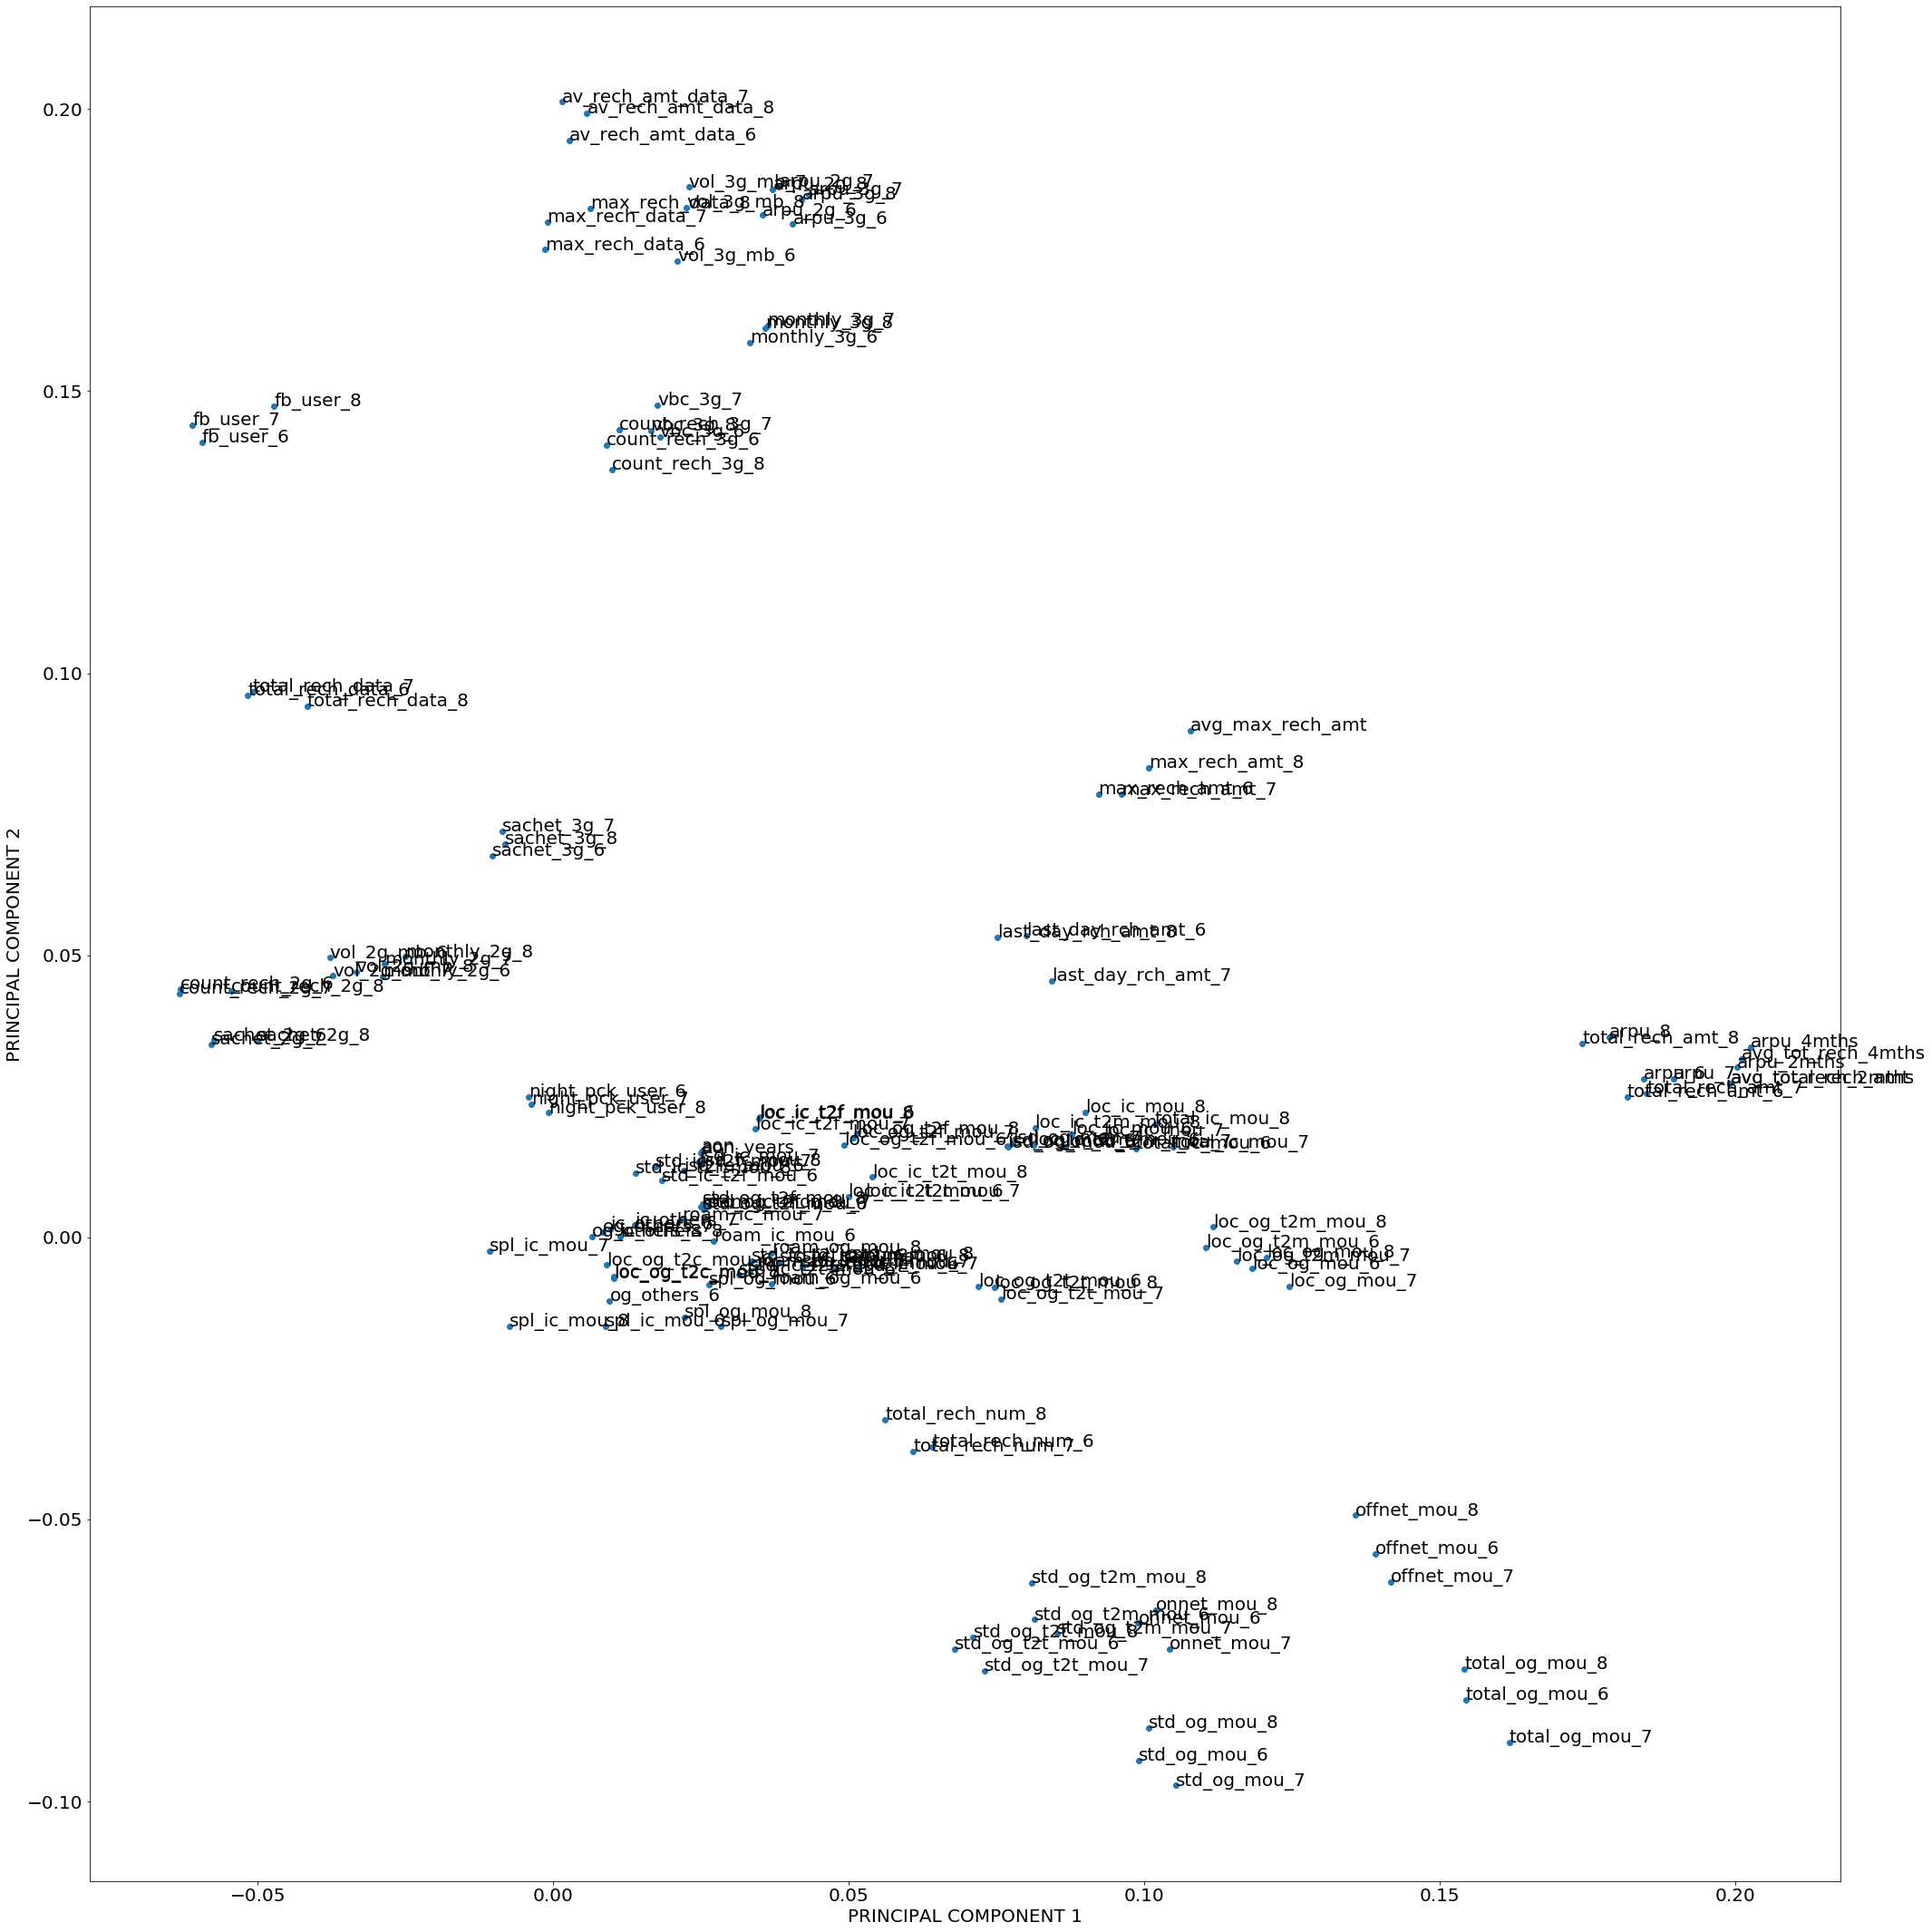

In [112]:
fig = plt.figure(figsize = (30,30))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('PRINCIPAL COMPONENT 1')
plt.ylabel('PRINCIPAL COMPONENT 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
    plt.tight_layout()
plt.show()

# IMPORTING LIBRARIES

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [114]:
df_train_pca.shape

(30088, 82)

# TRAINING REG MODEL

In [115]:
LogSk_learner_pca2 = LogisticRegression(class_weight='balanced')
model_pca2 = LogSk_learner_pca2.fit(df_train_pca,y_train)

# PREDICTING USING TEST DATA

In [116]:
pred_probs_test= model_pca2.predict_proba(df_test_pca)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.65'

In [117]:
y_predict_df = pd.DataFrame(pred_probs_test)

In [118]:
y_predict_df.head()

0
0  0.594802
1  0.070268
2  0.176933
3  0.001415
4  0.026457

In [119]:
# CONVERTING TO COL DF

In [120]:
y_predict_1 = y_predict_df.iloc[:,[0]]

In [121]:
y_predict_1.head()

0
0  0.594802
1  0.070268
2  0.176933
3  0.001415
4  0.026457

In [122]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn
11051      0
31613      0
38129      0
9203       0
17427      0

In [123]:
y_predict_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True,inplace=True)

In [124]:
y_predict_1.head()

0
0  0.594802
1  0.070268
2  0.176933
3  0.001415
4  0.026457

In [125]:
y_test_df.head()

churn
0      0
1      0
2      0
3      0
4      0

In [126]:
# CONCATINATING

In [127]:
y_predict_final = pd.concat([y_test_df,y_predict_1],axis=1)

In [128]:
y_predict_final.head(5)

churn         0
0      0  0.594802
1      0  0.070268
2      0  0.176933
3      0  0.001415
4      0  0.026457

# RENAMING FOR CLARITY

In [129]:
y_predict_final= y_predict_final.rename(columns={ 0 : 'Churn_Prob'})

In [130]:
# CHANGING INDEX
y_predict_final = y_predict_final.reindex(['churn','Churn_Prob'], axis=1)

In [131]:
y_predict_final.head(5)

churn  Churn_Prob
0      0    0.594802
1      0    0.070268
2      0    0.176933
3      0    0.001415
4      0    0.026457

# MAKING NEW COL FOR CHURN PROB GREATER THAN 0.5

In [132]:
y_predict_final['predicted'] = y_predict_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [133]:
y_predict_final.head(5)

churn  Churn_Prob  predicted
0      0    0.594802          1
1      0    0.070268          0
2      0    0.176933          0
3      0    0.001415          0
4      0    0.026457          0

# CONFUSION MATRIX

In [134]:
confusion = metrics.confusion_matrix( y_predict_final.churn, y_predict_final.predicted )
confusion

array([[9598, 2530],
       [ 482,  286]], dtype=int64)

Text(0.5, 6.0, 'PREDICTED LABEL')

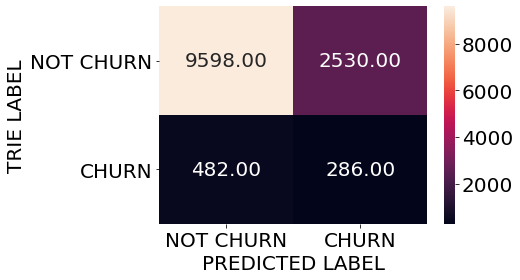

In [135]:
sns.heatmap(confusion, annot=True,  fmt='.2f', xticklabels = ["NOT CHURN", "CHURN"] , yticklabels = ["NOT CHURN", "CHURN"] )
plt.ylabel('TRIE LABEL')
plt.xlabel('PREDICTED LABEL')

# CHECKING ACCURACY

In [136]:
metrics.accuracy_score( y_predict_final.churn, y_predict_final.predicted)

0.766439205955335

In [137]:
TP = confusion[0,0] # true positive 
TN = confusion[1,1] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [138]:
print(TP)
print(TN)
print(FP)
print(FN)

9598
286
2530
482


# CREATING COL OF DIFF PROB CUTOFF

In [139]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_predict_final[i]= y_predict_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_predict_final.head(5)

churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      0    0.594802          1    1    1    1    1    1    1    0    0    0   
1      0    0.070268          0    1    0    0    0    0    0    0    0    0   
2      0    0.176933          0    1    1    0    0    0    0    0    0    0   
3      0    0.001415          0    1    0    0    0    0    0    0    0    0   
4      0    0.026457          0    1    0    0    0    0    0    0    0    0   

   0.9  
0    0  
1    0  
2    0  
3    0  
4    0

# CALCU;ATING ACCURACY, SENSITIVITY & SPECIFICITY

In [140]:
cutoff_df = pd.DataFrame( columns = ['PROBAB','ACCU','SENSI','SPECI'])
from sklearn.metrics import confusion_matrix

In [141]:
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_predict_final.churn, y_predict_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     PROBAB      ACCU     SENSI     SPECI
0.0     0.0  0.059553  0.000000  1.000000
0.1     0.1  0.273883  0.233922  0.904948
0.2     0.2  0.426101  0.402292  0.802083
0.3     0.3  0.562267  0.554420  0.686198
0.4     0.4  0.675403  0.685356  0.518229
0.5     0.5  0.766439  0.791392  0.372396
0.6     0.6  0.832894  0.869063  0.261719
0.7     0.7  0.879963  0.924720  0.173177
0.8     0.8  0.907646  0.958031  0.111979
0.9     0.9  0.923232  0.977985  0.058594


# PLOTTING PROB V/S ACCU,SENSI,SPECI

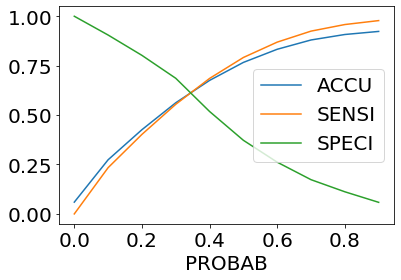

In [142]:
cutoff_df.plot.line(x='PROBAB', y=['ACCU','SENSI','SPECI'])

In [143]:
y_predict_final['final_predicted'] = y_predict_final.Churn_Prob.map( lambda x: 1 if x > 0.4 else 0)

# CHECKING ACCURACY

In [144]:
metrics.accuracy_score( y_predict_final.churn, y_predict_final.final_predicted)

0.6754032258064516

In [145]:
metrics.confusion_matrix( y_predict_final.churn, y_predict_final.final_predicted )

array([[8312, 3816],
       [ 370,  398]], dtype=int64)

Text(0.5, 6.0, 'PREDICTED LABEL')

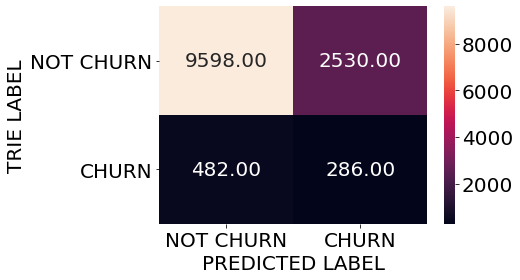

In [146]:
sns.heatmap(confusion, annot=True,  fmt='.2f', xticklabels = ["NOT CHURN", "CHURN"] , yticklabels = ["NOT CHURN", "CHURN"] )
plt.ylabel('TRIE LABEL')
plt.xlabel('PREDICTED LABEL')

# BUILDING AND EVALUATING MODEL


# PERFORMING XGBOOST 

# IMPORTING REQUIRED LIBRARIES

In [147]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [148]:
#MAKING A COPY

In [149]:
df_boost = df

In [150]:
# REMOVING NON ESSENTIAL COLS

In [151]:
df_boost = df_boost.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8', 'aon_group', 'arpu_group_2mths', 'arpu_group_4mths', 'max_rech_amt_group_2mths', 'total_rech_amt_group_2mths'],axis=1)

In [152]:
# STANDARDIZING DATA

In [153]:
from sklearn.model_selection import train_test_split
X = df_boost.drop(['churn'],axis=1)
y = df_boost['churn']

In [154]:
#SPLITTING DATA

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

# FITTING MODEL ON TRAIN DATA

In [156]:
model_boost = XGBClassifier()
model_boost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

# MAKINF PREDICTION FOR TEST DATA

In [157]:
y_predict = model_boost.predict_proba(X_test)
y_predict[:10]

array([[9.87985909e-01, 1.20140845e-02],
       [9.97511744e-01, 2.48822989e-03],
       [9.59082305e-01, 4.09176722e-02],
       [9.99895453e-01, 1.04550250e-04],
       [9.99821126e-01, 1.78867733e-04],
       [4.00272727e-01, 5.99727273e-01],
       [9.96010244e-01, 3.98977799e-03],
       [9.94790316e-01, 5.20968437e-03],
       [9.99391735e-01, 6.08285773e-04],
       [9.09677982e-01, 9.03220102e-02]], dtype=float32)

# EVALUATING PREDICTIONS

In [158]:
import sklearn.metrics as metrics
roc = metrics.roc_auc_score(y_test, y_predict[:, 1])
print("AREA UNDER CURVE: %.2f%%" % (roc * 100.0))

AREA UNDER CURVE: 90.35%


# HYPERPARAMETER TUNING

In [159]:
from sklearn.model_selection import GridSearchCV
folds = 3
# RANGE
para_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          

# SPECIFYING MODEL
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

model_xgb_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = para_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# FITTING MODEL

In [160]:
model_xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimato...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

# XGB_CV RESULTS

In [161]:
xgb_cv_results = pd.DataFrame(model_xgb_cv.cv_results_)
xgb_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.962053      0.274627         0.161501        0.011471   
1       8.620026      0.359767         0.120425        0.008741   
2       9.622485      0.351885         0.144816        0.006447   
3       9.180600      0.660292         0.153541        0.011136   
4      15.448621      1.676004         0.209219        0.020618   
5      13.497054      1.512615         0.179432        0.009332   

  param_learning_rate param_subsample  \
0                 0.2             0.3   
1                 0.2             0.6   
2                 0.2             0.9   
3                 0.6             0.3   
4                 0.6             0.6   
5                 0.6             0.9   

                                     params  split0_test_score  \
0  {'learning_rate': 0.2, 'subsample': 0.3}           0.891134   
1  {'learning_rate': 0.2, 'subsample': 0.6}           0.905478   
2  {'learning_rate': 0.2, 'subsample': 0.9}           0.903766   
3  {'learning_rate': 0.6, 'subsample': 0.3}           0.856348   
4  {'learning_rate': 0.6, 'subsample': 0.6}           0.870039   
5  {'learning_rate': 0.6, 'subsample': 0.9}           0.882075   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.892950           0.883252         0.889112        0.004210   
1           0.899807           0.890791         0.898692        0.006048   
2           0.903996           0.893173         0.900311        0.005049   
3           0.855812           0.851027         0.854396        0.002392   
4           0.873580           0.860857         0.868159        0.005362   
5           0.888369           0.864372         0.878272        0.010159   

   rank_test_score  split0_train_score  split1_train_score  \
0                3            0.946998            0.946316   
1                2            0.954213            0.953492   
2                1            0.955347            0.956035   
3                6            0.948677            0.953550   
4                5            0.975030            0.973955   
5                4            0.982942            0.983069   

   split2_train_score  mean_train_score  std_train_score  
0            0.950307          0.947874         0.001743  
1            0.956719          0.954808         0.001383  
2            0.957469          0.956284         0.000884  
3            0.952221          0.951483         0.002057  
4            0.978639          0.975875         0.002004  
5            0.983468          0.983160         0.000224

# PLOTTING GRAPHS

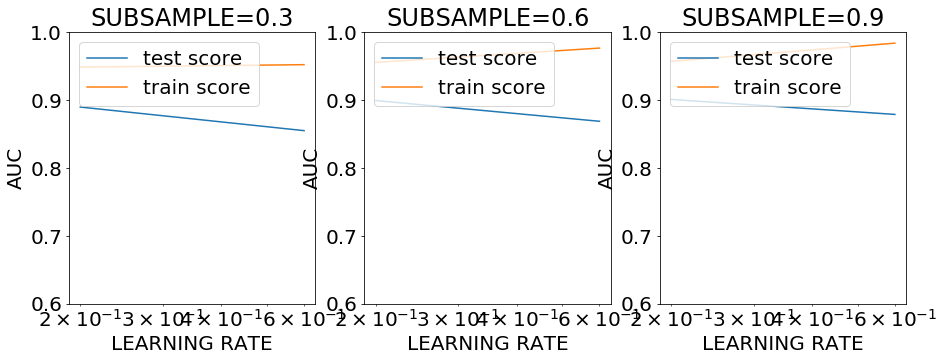

In [162]:

plt.figure(figsize=(15,5))

para_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(para_grid['subsample']):
    

    plt.subplot(1,len(para_grid['subsample']), n+1)
    plot_df = xgb_cv_results[xgb_cv_results['param_subsample']==subsample]

    plt.plot(plot_df["param_learning_rate"], plot_df["mean_test_score"])
    plt.plot(plot_df["param_learning_rate"], plot_df["mean_train_score"])
    plt.xlabel('LEARNING RATE')
    plt.ylabel('AUC')
    plt.title("SUBSAMPLE={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

# FROM ABOVE PLOTS IT CAN BE CONCLUDED THAT LEARNING RATE 0.2 AND SUBSAMPLE 0.9 SHOULD BE SELECTED AS THEY HAVE HIGHER AUC

In [163]:
# CHOOSING HYPERPARA

param = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# FITING MODEL 
model_boost = XGBClassifier(params = param)
model_boost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [164]:
# PREDICTING

In [165]:
y_predict_actual = model_boost.predict(X_test)
y_predict = model_boost.predict_proba(X_test)
y_predict[:10]

array([[9.87985909e-01, 1.20140845e-02],
       [9.97511744e-01, 2.48822989e-03],
       [9.59082305e-01, 4.09176722e-02],
       [9.99895453e-01, 1.04550250e-04],
       [9.99821126e-01, 1.78867733e-04],
       [4.00272727e-01, 5.99727273e-01],
       [9.96010244e-01, 3.98977799e-03],
       [9.94790316e-01, 5.20968437e-03],
       [9.99391735e-01, 6.08285773e-04],
       [9.09677982e-01, 9.03220102e-02]], dtype=float32)

# AUC

In [166]:
import sklearn
auc = sklearn.metrics.roc_auc_score(y_test, y_predict[:, 1])
auc

0.9035296679172162

### AUC is 90.35 %

### ACCURACY, SENSITIVITY AND SPECIFICITY OF TEST DATA

In [167]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

confusion_matrix_testData = confusion_matrix(y_test,y_predict_actual)
print(confusion_matrix(y_test,y_predict_actual))

total1=sum(sum(confusion_matrix_testData))
accuracy_1=(confusion_matrix_testData[0,0]+confusion_matrix_testData[1,1])/total1
print ('ACCURACY : ', accuracy_1)

sensitivity_1 = confusion_matrix_testData[0,0]/(confusion_matrix_testData[0,0]+confusion_matrix_testData[0,1])
print('SENSITIVITY  : ', sensitivity_1 )

specificity_1 = confusion_matrix_testData[1,1]/(confusion_matrix_testData[1,0]+confusion_matrix_testData[1,1])
print('SPECIFICITY : ', specificity_1)

[[11958   170]
 [  499   269]]
ACCURACY :  0.9481234491315137
SENSITIVITY  :  0.9859828496042217
SPECIFICITY :  0.3502604166666667


### ACCURACY, SENSITIVITY AND SPECIFICITY OF TRAIN DATA

In [168]:
y_predict_train = model_boost.predict(X_train)

In [169]:
confusion_matrix_trainData = confusion_matrix(y_train,y_predict_train)
print(confusion_matrix_trainData)
total2=sum(sum(confusion_matrix_trainData))
accuracy_2=(confusion_matrix_trainData[0,0]+confusion_matrix_trainData[1,1])/total2
print ('ACCURACY : ', accuracy_2)

sensitivity_2 = confusion_matrix_trainData[0,0]/(confusion_matrix_trainData[0,0]+confusion_matrix_trainData[0,1])
print('SENSITIVITY : ', sensitivity_2 )

specificity_2 = confusion_matrix_trainData[1,1]/(confusion_matrix_trainData[1,0]+confusion_matrix_trainData[1,1])
print('SPECIFICITY : ', specificity_2)

[[28336     7]
 [   73  1672]]
ACCURACY :  0.9973411326774794
SENSITIVITY :  0.9997530254383798
SPECIFICITY :  0.9581661891117479


### THERE ISNT MUCH DEVIATION IN TRAIN AND TEST DATA WHICH INDICATES THE MODEL ISNT OVERFITTING

# IMP FEATURES

In [170]:
imp_features = dict(zip(X_train.columns, model_boost.feature_importances_))
imp_features

{'mobile_number': 0.003756265,
 'arpu_6': 0.004465337,
 'arpu_7': 0.0055173733,
 'arpu_8': 0.0036477572,
 'onnet_mou_6': 0.0044528055,
 'onnet_mou_7': 0.003482782,
 'onnet_mou_8': 0.004682706,
 'offnet_mou_6': 0.004340697,
 'offnet_mou_7': 0.0041709747,
 'offnet_mou_8': 0.003820831,
 'roam_ic_mou_6': 0.004768058,
 'roam_ic_mou_7': 0.007527679,
 'roam_ic_mou_8': 0.0070394226,
 'roam_og_mou_6': 0.0038535781,
 'roam_og_mou_7': 0.009063143,
 'roam_og_mou_8': 0.018775603,
 'loc_og_t2t_mou_6': 0.0031718186,
 'loc_og_t2t_mou_7': 0.0034246207,
 'loc_og_t2t_mou_8': 0.004229794,
 'loc_og_t2m_mou_6': 0.0034823534,
 'loc_og_t2m_mou_7': 0.0042177634,
 'loc_og_t2m_mou_8': 0.0064142295,
 'loc_og_t2f_mou_6': 0.003480168,
 'loc_og_t2f_mou_7': 0.0049769725,
 'loc_og_t2f_mou_8': 0.009730889,
 'loc_og_t2c_mou_6': 0.0032073427,
 'loc_og_t2c_mou_7': 0.0053885803,
 'loc_og_t2c_mou_8': 0.00393658,
 'loc_og_mou_6': 0.003489287,
 'loc_og_mou_7': 0.0040108706,
 'loc_og_mou_8': 0.0055193193,
 'std_og_t2t_mou_6': 

In [171]:
import operator
columns_sorted_descending_importance = sorted(imp_features.items(), key=operator.itemgetter(1),reverse=True)

In [172]:
columns_sorted_descending_importance

[('fb_user_8', 0.18968524),
 ('total_ic_mou_8', 0.046158966),
 ('loc_ic_mou_8', 0.042427126),
 ('av_rech_amt_data_8', 0.020675302),
 ('roam_og_mou_8', 0.018775603),
 ('last_day_rch_amt_8', 0.015230377),
 ('fb_user_7', 0.014977695),
 ('spl_ic_mou_8', 0.0137017155),
 ('loc_og_t2f_mou_8', 0.009730889),
 ('roam_og_mou_7', 0.009063143),
 ('isd_og_mou_6', 0.007983546),
 ('std_og_mou_7', 0.0076696803),
 ('total_rech_amt_8', 0.007637835),
 ('loc_ic_t2m_mou_8', 0.0076068235),
 ('vol_2g_mb_8', 0.0076064123),
 ('isd_og_mou_8', 0.0075770924),
 ('roam_ic_mou_7', 0.007527679),
 ('total_og_mou_8', 0.0074913176),
 ('count_rech_3g_6', 0.0071507217),
 ('roam_ic_mou_8', 0.0070394226),
 ('loc_ic_mou_7', 0.006973034),
 ('total_rech_num_7', 0.0066615),
 ('max_rech_data_8', 0.0066307997),
 ('loc_ic_t2f_mou_8', 0.0065896395),
 ('loc_og_t2m_mou_8', 0.0064142295),
 ('vbc_3g_7', 0.006167799),
 ('isd_og_mou_7', 0.0061147823),
 ('total_rech_data_7', 0.005671851),
 ('total_ic_mou_7', 0.0056553497),
 ('std_og_mou_8'

## RANDOM FOREST

In [173]:
X_train.shape

(30088, 159)

In [174]:
# IMPORTING LIB AND RUNNING RANDOM FOREST

In [175]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(class_weight={0:0.9,1:0.9})

In [176]:
# FITTING RFC
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.9, 1: 0.9}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [177]:
# MAKIN PREDICTIONS
predictions = rfc.predict(X_test)

In [178]:
# IMPORTING REQUIRED PACKAGES
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [179]:
# CHECKING DEFAULT MODEL
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12128
           1       0.64      0.26      0.37       768

    accuracy                           0.95     12896
   macro avg       0.80      0.63      0.67     12896
weighted avg       0.94      0.95      0.94     12896



In [180]:
# COMFUSION MATRIX
print(confusion_matrix(y_test,predictions))

[[12015   113]
 [  565   203]]


In [181]:
# ACCURACY SCORE
print(accuracy_score(y_test,predictions))

0.9474255583126551


In [182]:
# USING GRID SEARCH 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_folds = 5
parameters = {'max_depth': range(2, 20, 5)}

rf = RandomForestClassifier()
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [183]:
# SCORES OF GRID SEARCH
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.930958      0.378986         0.092843        0.017637   
1      18.083752      0.344656         0.153390        0.021892   
2      27.838945      2.163932         0.213653        0.028714   
3      35.899300      0.462180         0.275452        0.018127   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               2   {'max_depth': 2}           0.942007           0.942007   
1               7   {'max_depth': 7}           0.949153           0.949983   
2              12  {'max_depth': 12}           0.949153           0.950482   
3              17  {'max_depth': 17}           0.949817           0.951313   

   split2_test_score  split3_test_score  ...  mean_test_score  std_test_score  \
0           0.942007           0.941998  ...         0.942003        0.000005   
1           0.949319           0.948812  ...         0.949216        0.000431   
2           0.949983           0.948313  ...         0.949481        0.000738   
3           0.948986           0.947815  ...         0.949415        0.001147   

   rank_test_score  split0_train_score  split1_train_score  \
0                4            0.942002            0.942002   
1                3            0.952887            0.954134   
2                1            0.973203            0.974699   
3                2            0.990943            0.990943   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.942002            0.942005            0.942005   
1            0.953885            0.953637            0.953886   
2            0.973993            0.975365            0.974160   
3            0.990902            0.990985            0.991608   

   mean_train_score  std_train_score  
0          0.942003         0.000001  
1          0.953686         0.000429  
2          0.974284         0.000722  
3          0.991076         0.000267  

[4 rows x 21 columns]

# PLOTTING MAX DEPTH

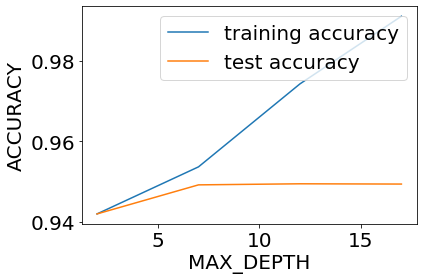

In [184]:
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("MAX_DEPTH")
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

In [185]:
# GRID SEARCH FOR OPTIMAL ESTIMATORS
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


n_folds = 5
parameters = {'n_estimators': range(1, 10, 1)}
rf = RandomForestClassifier()
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [186]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.534156      0.123592         0.022846        0.004979   
1       0.968273      0.101056         0.027909        0.006359   
2       1.346574      0.062068         0.030892        0.002876   
3       1.773874      0.126189         0.031356        0.006300   
4       2.150756      0.208542         0.031679        0.005512   

  param_n_estimators               params  split0_test_score  \
0                  1  {'n_estimators': 1}           0.913593   
1                  2  {'n_estimators': 2}           0.943004   
2                  3  {'n_estimators': 3}           0.940013   
3                  4  {'n_estimators': 4}           0.943669   
4                  5  {'n_estimators': 5}           0.944666   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.915753           0.914423           0.918232  ...   
1           0.942007           0.939515           0.943161  ...   
2           0.938352           0.941675           0.934685  ...   
3           0.944334           0.942173           0.946651  ...   
4           0.944167           0.945995           0.942662  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.915415        0.001579                9            0.968259   
1         0.942303        0.001511                7            0.974616   
2         0.939045        0.002428                8            0.986913   
3         0.944729        0.001781                5            0.982883   
4         0.944363        0.001067                6            0.990985   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.969339            0.969215            0.969175   
1            0.974283            0.974159            0.973412   
2            0.986332            0.987661            0.987578   
3            0.983548            0.984254            0.983092   
4            0.990985            0.992273            0.991567   

   split4_train_score  mean_train_score  std_train_score  
0            0.969673          0.969132         0.000470  
1            0.974284          0.974151         0.000399  
2            0.986789          0.987055         0.000501  
3            0.984712          0.983698         0.000692  
4            0.991650          0.991492         0.000481  

[5 rows x 21 columns]

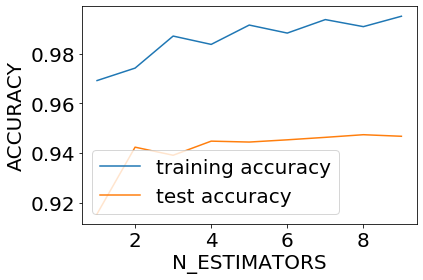

In [187]:
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("N_ESTIMATORS")
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

In [188]:
# GRID SEARCH TO FIND N-ESTIMATOR
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_folds = 5
parameters = {'max_features': [10, 25, 50, 75 , 100]} 
rf = RandomForestClassifier()
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [189]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      32.582495      2.658348         0.297430        0.020713   
1      88.754984      3.510424         0.315740        0.064707   
2     193.040288     10.712389         0.299127        0.007748   
3     305.067973     15.299103         0.264838        0.009319   
4     413.628118     14.636388         0.267847        0.010087   

  param_max_features                 params  split0_test_score  \
0                 10   {'max_features': 10}           0.949153   
1                 25   {'max_features': 25}           0.949983   
2                 50   {'max_features': 50}           0.949817   
3                 75   {'max_features': 75}           0.950150   
4                100  {'max_features': 100}           0.948986   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.951479           0.949983           0.947815  ...   
1           0.949319           0.950482           0.948479  ...   
2           0.951479           0.951147           0.949643  ...   
3           0.950150           0.949153           0.949975  ...   
4           0.952310           0.950814           0.948313  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.949581        0.001190                4            0.999958   
1         0.949415        0.000736                5            0.999958   
2         0.950479        0.000723                1            0.999958   
3         0.949947        0.000411                3            0.999958   
4         0.950346        0.001482                2            1.000000   

   split1_train_score  split2_train_score  split3_train_score  \
0            1.000000            0.999958            0.999958   
1            1.000000            0.999958            1.000000   
2            1.000000            1.000000            1.000000   
3            0.999958            0.999958            0.999958   
4            0.999958            0.999958            1.000000   

   split4_train_score  mean_train_score  std_train_score  
0            1.000000          0.999975         0.000020  
1            0.999875          0.999958         0.000046  
2            1.000000          0.999992         0.000017  
3            1.000000          0.999967         0.000017  
4            0.999958          0.999975         0.000020  

[5 rows x 21 columns]

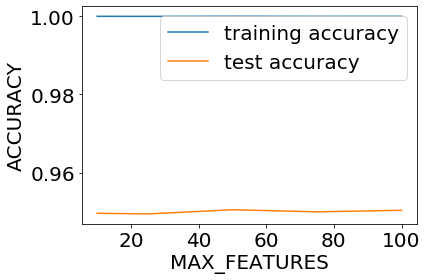

In [190]:
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("MAX_FEATURES")
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

In [191]:
# MAKIN PARAMETER GRID BASED ON RANDOM FOREST
param_grid = {     'max_depth': [2,4,6],
                   'n_estimators': [1,2,3],
                   'max_features': [5,15,25] } 


rf = RandomForestClassifier() 
model_GSV = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 3, n_jobs = -1,verbose = 1) 
model_GSV.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   10.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [192]:
print('ACCURACY=',model_GSV.best_score_,'FOR=',model_GSV.best_params_)

ACCURACY= 0.9487171052402669 FOR= {'max_depth': 4, 'max_features': 25, 'n_estimators': 3}


# MAKING MODEL BY SELECTED HYPERPARAMETERS

In [193]:
rfc_selected = RandomForestClassifier(bootstrap=True,         max_depth=4,
                                                           max_features=20,
                                                           n_estimators=2,
                                                           class_weight={0:0.9,1:0.9}) 
rfc_selected.fit(X_train,y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.9, 1: 0.9}, criterion='gini',
                       max_depth=4, max_features=20, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [194]:
predictions_of_selected = rfc_selected.predict(X_test)

In [195]:
predictions_of_selected

array([0, 0, 0, ..., 0, 0, 0])

In [196]:
print(metrics.classification_report(y_test,predictions_of_selected))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12128
           1       0.62      0.26      0.36       768

    accuracy                           0.95     12896
   macro avg       0.79      0.62      0.67     12896
weighted avg       0.93      0.95      0.94     12896



In [197]:
#CONFUSION MATRIX

In [198]:
print(confusion_matrix(y_test,predictions_of_selected))

[[12007   121]
 [  570   198]]


In [199]:
#ACCURACY SCORE

In [200]:
print(accuracy_score(y_test,predictions_of_selected))

0.9464174937965261


In [201]:
import pandas as pd
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [202]:
feature_importances.head(25)

importance
loc_ic_t2m_mou_8      0.040064
total_ic_mou_8        0.030537
loc_ic_mou_8          0.030443
roam_og_mou_8         0.021000
roam_ic_mou_8         0.019953
total_og_mou_8        0.019818
loc_ic_t2t_mou_8      0.019199
total_rech_amt_8      0.016288
arpu_8                0.014762
loc_og_mou_8          0.013479
loc_og_t2m_mou_8      0.013288
last_day_rch_amt_8    0.013197
mobile_number         0.011035
aon                   0.010958
max_rech_amt_8        0.010552
av_rech_amt_data_8    0.010238
arpu_7                0.010140
total_ic_mou_7        0.009986
arpu_6                0.009980
offnet_mou_6          0.009974
offnet_mou_8          0.009876
arpu_2mths            0.009864
loc_ic_t2m_mou_7      0.009698
loc_ic_mou_7          0.009620
avg_total_rech_amt    0.009429

In [203]:
import pandas as pd
imp_feature_after_HPTuning= pd.DataFrame(rfc_selected.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
imp_feature_after_HPTuning.head(10)

importance
loc_ic_mou_8         0.308840
loc_ic_t2m_mou_8     0.278693
arpu_3g_8            0.066545
total_rech_data_7    0.054421
total_rech_amt_8     0.053932
std_og_mou_7         0.044828
roam_og_mou_8        0.036827
total_ic_mou_8       0.026386
roam_ic_mou_8        0.020525
offnet_mou_6         0.012747

In [1]:
#X = df
##from sklearn.preprocessing import MinMaxScaler
#features = X.columns.values
#X = pd.DataFrame(scaler.transform(X))
#X.columns = features

#importances = model_rf.feature_importances_
#weights = pd.DataFrame(rfc_selected.feature_importances_,
#                                   index = X_train.columns,
#                                    columns=['importance']).sort_values('importance',ascending=False)
#weights.sort_values()[-10:].plot(kind = 'barh')

# HERE ARE THE TOP IMP FEATURS 

### loc_ic_mou_8	

### loc_ic_t2m_mou_8	

### arpu_3g_8	

### total_rech_data_7	

### total_rech_amt_8

### std_og_mou_7	

### roam_og_mou_8	

### total_ic_mou_8	

### roam_ic_mou_8

### offnet_mou_6	


In [205]:
print(max(rfc.feature_importances_))

0.040063771104128926


In [206]:
print(max(rfc_selected.feature_importances_))

0.3088397581357654


In [207]:
# PREDICTING USING TEST DATA

In [208]:
predict_prob_test= rfc_selected.predict_proba(X_test)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, predict_prob_test))

'0.85'

In [209]:
y_predict_df = pd.DataFrame(predict_prob_test)
y_predict_df.head(5)

0
0  0.036054
1  0.014137
2  0.367044
3  0.014137
4  0.014137

In [210]:
y_predict_1 = y_predict_df.iloc[:,[0]]
y_predict_1.head(5)

0
0  0.036054
1  0.014137
2  0.367044
3  0.014137
4  0.014137

In [211]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head(5)

churn
11051      0
31613      0
38129      0
9203       0
17427      0

In [212]:
y_predict_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True,inplace=True)

In [213]:
y_predict_1.head(5)

0
0  0.036054
1  0.014137
2  0.367044
3  0.014137
4  0.014137

In [214]:
y_test_df.head(5)

churn
0      0
1      0
2      0
3      0
4      0

In [215]:
#CONCATINATING y_test_& y_predict_1

In [216]:
y_predict_final_1 = pd.concat([y_test_df,y_predict_1],axis=1)

In [217]:
y_predict_final_1.head(5)

churn         0
0      0  0.036054
1      0  0.014137
2      0  0.367044
3      0  0.014137
4      0  0.014137

In [218]:
y_predict_final_1= y_predict_final_1.rename(columns={ 0 : 'Churn_Prob'})

In [219]:
y_predict_final_1 = y_predict_final_1.reindex(['churn','Churn_Prob'], axis=1)

In [220]:
# CHECKING y_predict_final_1

In [221]:
y_predict_final_1.head(5)

churn  Churn_Prob
0      0    0.036054
1      0    0.014137
2      0    0.367044
3      0    0.014137
4      0    0.014137

In [222]:
# MAKING A NEW COLOMUN WITH DATA OF CHURN PROB > .5

In [223]:
y_predict_final_1['predicted'] = y_predict_final_1.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [224]:
y_predict_final_1.head(5)

churn  Churn_Prob  predicted
0      0    0.036054          0
1      0    0.014137          0
2      0    0.367044          0
3      0    0.014137          0
4      0    0.014137          0

In [225]:
# CONFUSION MATRIX

In [226]:
confusion = metrics.confusion_matrix( y_predict_final_1.churn, y_predict_final_1.predicted )
confusion

array([[12007,   121],
       [  570,   198]], dtype=int64)

In [227]:
# CHECKING ACCURACY

In [228]:
metrics.accuracy_score( y_predict_final_1.churn, y_predict_final_1.predicted)

0.9464174937965261

In [229]:
# MAKINF COLS WITH DIFF CUTOFFS

In [230]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_predict_final_1[i]= y_predict_final_1.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_predict_final_1.head(5)

churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      0    0.036054          0    1    0    0    0    0    0    0    0    0   
1      0    0.014137          0    1    0    0    0    0    0    0    0    0   
2      0    0.367044          0    1    1    1    1    0    0    0    0    0   
3      0    0.014137          0    1    0    0    0    0    0    0    0    0   
4      0    0.014137          0    1    0    0    0    0    0    0    0    0   

   0.9  
0    0  
1    0  
2    0  
3    0  
4    0

# CALCULATING ACCURACY, SENSITIVITY & SPECIFICITY

In [231]:
cutoff_df_final = pd.DataFrame( columns = ['PROBAB','ACCU','SENSI','SPECI'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_predict_final_1.churn, y_predict_final_1[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df_final.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df_final)

     PROBAB      ACCU     SENSI     SPECI
0.0     0.0  0.059553  0.000000  1.000000
0.1     0.1  0.881514  0.896768  0.640625
0.2     0.2  0.934088  0.968255  0.394531
0.3     0.3  0.942153  0.981860  0.315104
0.4     0.4  0.945099  0.987385  0.277344
0.5     0.5  0.946417  0.990023  0.257812
0.6     0.6  0.945254  0.994228  0.171875
0.7     0.7  0.940834  0.999753  0.010417
0.8     0.8  0.940447  1.000000  0.000000
0.9     0.9  0.940447  1.000000  0.000000


# PLOTTING ACCURACY, SENSITIVITY & SPECIFICITY

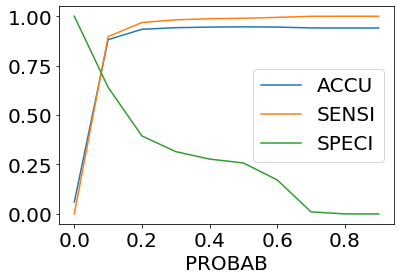

In [232]:
cutoff_df_final.plot.line(x='PROBAB', y=['ACCU','SENSI','SPECI'])

In [233]:
y_predict_final_1['final_predicted'] = y_predict_final_1.Churn_Prob.map( lambda x: 1 if x > 0.1 else 0)

# ACCURACY

In [234]:
metrics.accuracy_score( y_predict_final_1.churn, y_predict_final_1.final_predicted)

0.8815136476426799

In [235]:
metrics.confusion_matrix( y_predict_final_1.churn, y_predict_final_1.final_predicted )

array([[10876,  1252],
       [  276,   492]], dtype=int64)

In [236]:
import pandas as pd
imp_features_after_HPTuning= pd.DataFrame(rfc_selected.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
imp_features_after_HPTuning.head(10)

importance
loc_ic_mou_8         0.308840
loc_ic_t2m_mou_8     0.278693
arpu_3g_8            0.066545
total_rech_data_7    0.054421
total_rech_amt_8     0.053932
std_og_mou_7         0.044828
roam_og_mou_8        0.036827
total_ic_mou_8       0.026386
roam_ic_mou_8        0.020525
offnet_mou_6         0.012747

# MODEL EVALUATION

## RESULTS OF PCA(Logistic Regression):
CONFUSION MATRIX:

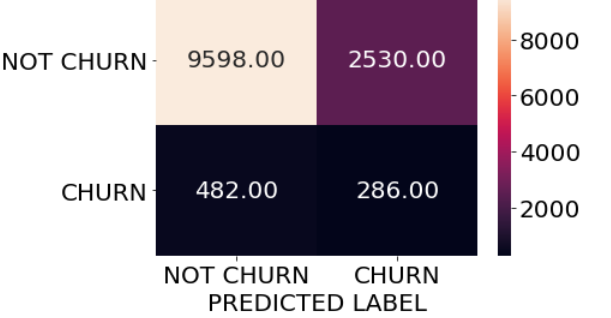
 


ACCURACY: 0.766439205955335

## RESULTS OF XGBOOST MODEL:
CONFUSION MATRIX:

[[28336     7]

 [   73  1672]]
 
 
 
ACCURACY :  0.9973411326774794

SENSITIVITY  :  0.9997530254383798

SPECIFICITY :   0.9581661891117479

## RESULTS OF RANDOM FOREST:
CONFUSION MATRIX:

[[12007,   121],

   [  570,   198]]

ACCURACY: 0.9464174937965261

ACCURACY IS CALCULATED USING AUC HERE.
ITS CLEAR THAT XGBOOST SUITS WELL TO FIND THE CHURNERS BASED ON THE VALUES ABOVE.


### DRIVER VARIABLES 

### EXTRACTED FROM XGBoost MODEL

BY ODER OF IMPORTANCE

('fb_user_8', 0.18968524),

 ('total_ic_mou_8', 0.046158966),
 
 ('loc_ic_mou_8', 0.042427126),
 
 ('av_rech_amt_data_8', 0.020675302),
 
 ('roam_og_mou_8', 0.018775603),
 
 ('last_day_rch_amt_8', 0.015230377),
 
 ('fb_user_7', 0.014977695),
 
 ('spl_ic_mou_8', 0.0137017155),
 
 ('loc_og_t2f_mou_8', 0.009730889),
 
 ('roam_og_mou_7', 0.009063143),
 
 ('isd_og_mou_6', 0.007983546),
 
 ('std_og_mou_7', 0.0076696803),
 
 ('total_rech_amt_8', 0.007637835),
 
 ('loc_ic_t2m_mou_8', 0.0076068235),
 
 ('vol_2g_mb_8', 0.0076064123),
 
 ('isd_og_mou_8', 0.0075770924),
 

### EXTRACTED FROM RANDOM FOREST

BY ODER OF IMPORTANCE

loc_ic_mou_8	0.308840

loc_ic_t2m_mou_8	0.278693

arpu_3g_8	0.066545

total_rech_data_7	0.054421

total_rech_amt_8	0.053932

std_og_mou_7	0.044828

roam_og_mou_8	0.036827

total_ic_mou_8	0.026386

roam_ic_mou_8	0.020525

offnet_mou_6	0.012747


### SELECTED FROM DRIVER VARIABLES

1. loc_ic_mou_8	

2. loc_ic_t2m_mou_8

3. arpu_3g_8	

4. total_rech_data_7	

5. total_rech_amt_8	

6. std_og_mou_7	

7. roam_og_mou_8	

8. total_ic_mou_8	

9. roam_ic_mou_8	

10. offnet_mou_6	


# OBSERVATIONS

From random forest method, Local Incoming for Month 8, Local Incoming calls from operator T to other operators for month 8 and average revenue per user  are most imp predictors that can predict churn

# RECOMMENDATION

### 1 offer packs with discounts on incoming packs
### 2 offer exclusive offers for customer having diverse profiles of incomming calls
### 3 give offers to loyal customers who have higher average revenue collectors
### 4 giver offers for 7th month of additional net (data) recharge packages
### 5 give offers on standard outgoing calls for 7th month